<a href="https://colab.research.google.com/github/jhlopesalves/classic_workflows/blob/main/supervised_learning/classification/titanic/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Titanic Dataset Overview

The Titanic dataset contains information about passengers aboard the RMS Titanic, including survival status, demographics, and travel details. It comprises **891 rows** and **12 columns**.

### Data Dictionary

| Variable        | Definition                              | Key/Notes                                                                                                      |
|-----------------|-----------------------------------------|----------------------------------------------------------------------------------------------------------------|
| **PassengerId** | Unique identifier for each passenger    | `int64` (not a predictive feature)                                                                             |
| **Survived**    | Survival status                         | `0 = No, 1 = Yes`                                                                                              |
| **Pclass**      | Ticket class                            | `1 = 1st (Upper), 2 = 2nd (Middle), 3 = 3rd (Lower)` | A proxy for socio-economic status (SES)            |
| **Name**        | Passenger's name                        | `object`                                                                                                       |
| **Sex**         | Sex                                     | `male`, `female`                                                                                               |
| **Age**         | Age in years                            | `float64` | Fractional if < 1; estimated ages in form xx.5                                                  |
| **SibSp**       | Number of siblings/spouses aboard       | `int64` | Sibling = brother, sister, stepbrother, stepsister; Spouse = husband, wife                        |
| **Parch**       | Number of parents/children aboard       | `int64` | Parent = mother, father; Child = daughter, son, stepdaughter, stepson                             |
| **Ticket**      | Ticket number                           | `object`                                                                                                       |
| **Fare**        | Passenger fare                          | `float64`                                                                                                      |
| **Cabin**       | Cabin number                            | `object`                                                                                                       |
| **Embarked**    | Port of embarkation                     | `C = Cherbourg, Q = Queenstown, S = Southampton`                                                               |

### Dataset Characteristics

- **Total passengers**: 891 (a sample of the actual 2,224 passengers and crew; this dataset contains passengers only)
- **Missing values**:
  - Age: 177 missing (714 non-null)
  - Cabin: 687 missing (204 non-null)
  - Embarked: 2 missing (889 non-null)
- **Target variable**: `Survived` (binary classification)
- **Key features**: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked

### Historical Context

The sinking of the RMS Titanic on 15 April 1912 during her maiden voyage remains one of the most infamous maritime disasters in history. The "unsinkable" ship struck an iceberg, resulting in the deaths of approximately 1,502 of the 2,224 passengers and crew. Insufficient lifeboats meant survival was influenced by factors beyond mere chance.

### The Analytical Challenge

This dataset presents an opportunity to build a predictive model answering the question: **"What sorts of people were more likely to survive?"**

By analysing passenger attributes such as:
- Socio-economic status (via Pclass)
- Gender and age demographics
- Family size (SibSp + Parch)
- Travel details (Fare, Embarked)

...we can uncover patterns in survival likelihood. This serves as a classic binary classification problem, combining historical analysis with machine learning.

### Environment Setup and Imports

This notebook uses the standard Python data science stack alongside scikit-learn for machine learning pipelines.

**Core stack**:
- `numpy`, `pandas`: numerical and tabular data manipulation
- `matplotlib`, `seaborn`: visualisation (Seaborn's object-oriented API preferred)

**Machine learning**:
- `sklearn.pipeline`, `sklearn.compose`: reproducible preprocessing pipelines
- `sklearn.model_selection`: cross-validation utilities
- `sklearn.metrics`: evaluation metrics for binary classification
- `sklearn.preprocessing`: encoders and scalers

**Utilities**:
- `re`: regular expressions for feature extraction from text fields
- `warnings`: to manage verbosity during model fitting
- `typing`, `numpy.typing`: type annotations for clarity

In [1]:
from __future__ import annotations

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import re
import warnings
from typing import Literal

from numpy.typing import ArrayLike
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer
from sklearn.metrics import average_precision_score, confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


## Loading the Training Data

The training dataset is loaded directly from a raw GitHub URL. This approach ensures:
1. **Reproducibility**: anyone can re-run the notebook without manual file downloads.
2. **Environment agnosticism**: works identically in Colab, Kaggle, or local Jupyter.

In [4]:
TRAIN_URL = "https://raw.githubusercontent.com/jhlopesalves/classic_workflows/main/supervised_learning/classification/titanic/data/train.csv"

train = pd.read_csv(TRAIN_URL)
train.shape

(891, 12)

### Initial Data Inspection

1. **Visual preview**: confirm the data loaded correctly and inspect representative rows.
2. **Schema summary**: verify column names, data types, and non-null counts.

In [5]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Exploratory Data Analysis (EDA)

This section investigates the structure of the data before modelling. Key areas:

1. **Missingness audit**: quantify and visualise missing values to inform imputation strategies.
2. **Feature distributions**: examine how passengers are distributed across categorical variables (Sex, Pclass, Embarked) and continuous variables (Age, Fare).
3. **Survival patterns**: analyse survival rates across demographic and socio-economic groups.
4. **Age analysis**: explore age distributions and their relationship with survival.
5. **Cabin information**: assess whether cabin availability (a proxy for data quality and possibly deck location) correlates with survival.

### Missingness Audit

In [7]:
missing = train.isna().sum().sort_values(ascending=False)
missing_pct = (missing / len(train) * 100).round(2)

pd.DataFrame({"missing_count": missing, "missing_pct": missing_pct}).query("missing_count > 0")

,missing_count,missing_pct
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22


### Preparing an EDA-Specific Dataframe

Before visualising, we create a dedicated copy of the training data (`train_eda`) with:
- **Human-readable labels**: Pclass and Embarked mapped to interpretable strings.
- **Derived features**: Cabin deck prefix (`CabinCode`), and binary missingness indicators for Cabin and Age.

This keeps the original data intact (`train_raw`) while allowing exploratory plots to display meaningful labels.

In [8]:
# Enables Seaborn to use matplotlib colour codes
sns.set_color_codes("bright")

In [9]:
# Preserve original data; create a separate copy for EDA with human-readable labels
train_eda = train.copy()

# Map Pclass to descriptive labels
train_eda["Pclass"] = train_eda["Pclass"].map({
	1: "1st (Upper)",
	2: "2nd (Middle)",
	3: "3rd (Lower)",
})

# Map Embarked codes to port names
train_eda["Embarked"] = train_eda["Embarked"].map({
	"C": "Cherbourg",
	"Q": "Queenstown",
	"S": "Southampton",
})

# Extract cabin deck prefix (first character)
train_eda["CabinCode"] = train_eda["Cabin"].str[0]

# Binary missingness indicators
train_eda["CabinMissing"] = train_eda["Cabin"].isna().map({True: "Missing", False: "Non-missing"})
train_eda["AgeMissing"] = train_eda["Age"].isna().map({True: "Missing", False: "Non-missing"})

# Map Survived to readable labels
train_eda["Survived"] = train_eda["Survived"].map({0: "No", 1: "Yes"})


### Survival Counts Across Key Categorical Features

The plots below show absolute survival counts for Sex, Pclass, Embarked, and Parch. Absolute counts (rather than proportions) reveal both the survival disparity and the sample size per category.

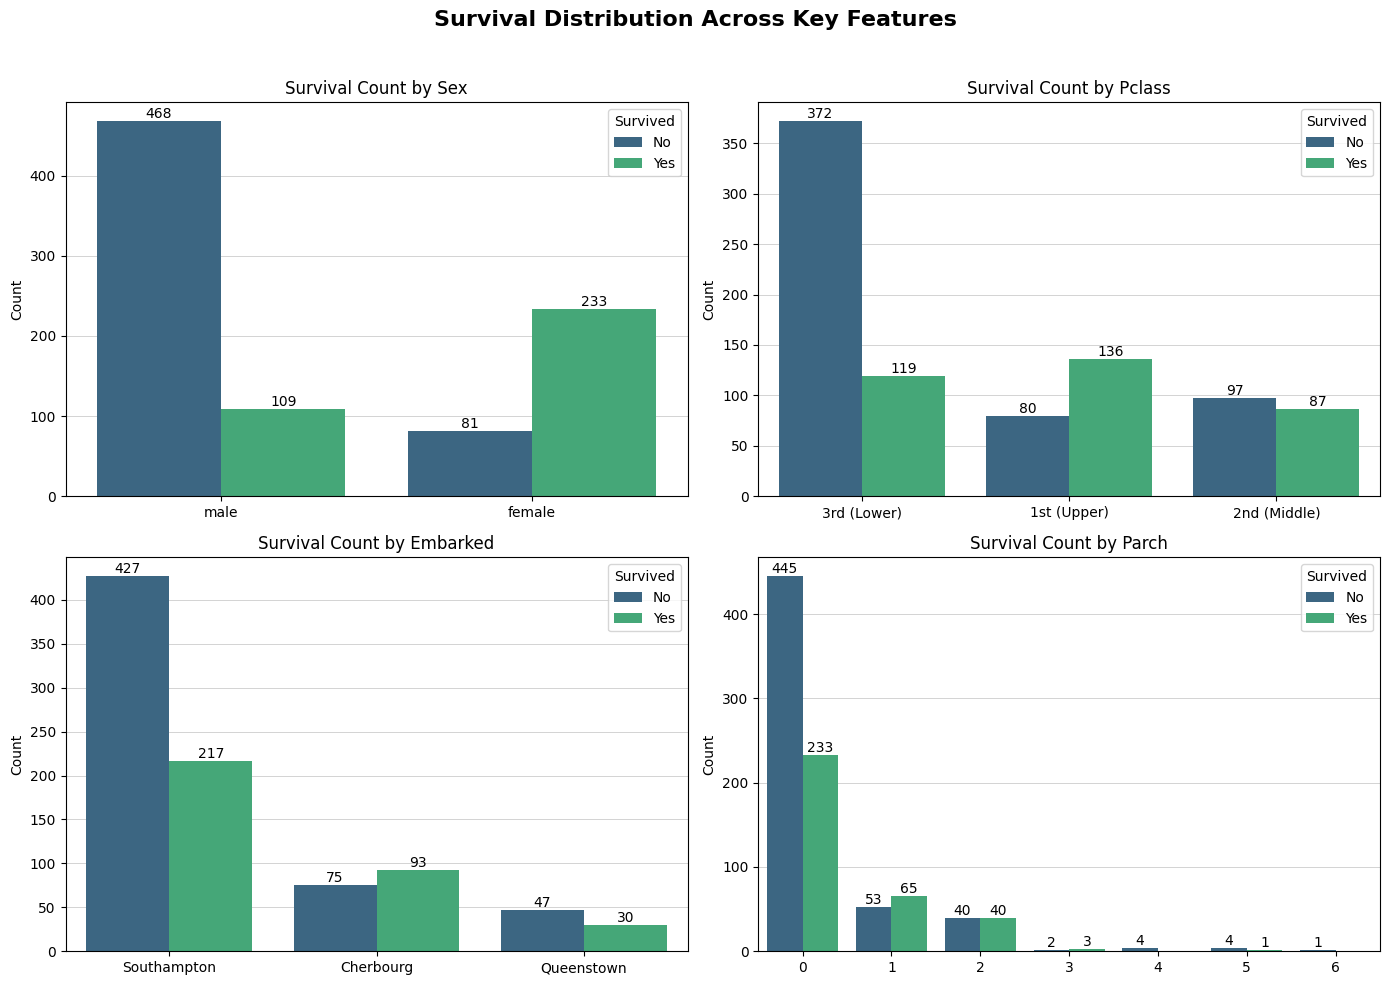

In [10]:
cols_of_interest = ["Sex", "Pclass", "Embarked", "Parch"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for ax, col in zip(axes, cols_of_interest):
	sns.countplot(data=train_eda, x=col, hue="Survived", palette="viridis", ax=ax)

	for container in ax.containers:
		ax.bar_label(container, fontsize=10)

	ax.set_title(f"Survival Count by {col}", fontsize=12)
	ax.set(xlabel="", ylabel="Count")
	ax.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax.set_axisbelow(True)
	ax.legend(title="Survived")

plt.suptitle("Survival Distribution Across Key Features", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Age Distribution by Survival Status

Three complementary views of the Age variable, stratified by survival outcome:
- **Boxplot**: median, quartiles, and outliers.
- **KDE**: smoothed density estimate revealing distributional shape.
- **ECDF**: empirical cumulative distribution, useful for comparing quantiles.

/tmp/ipython-input-1638803358.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_eda, x="Survived", y="Age", palette="viridis", ax=ax1)


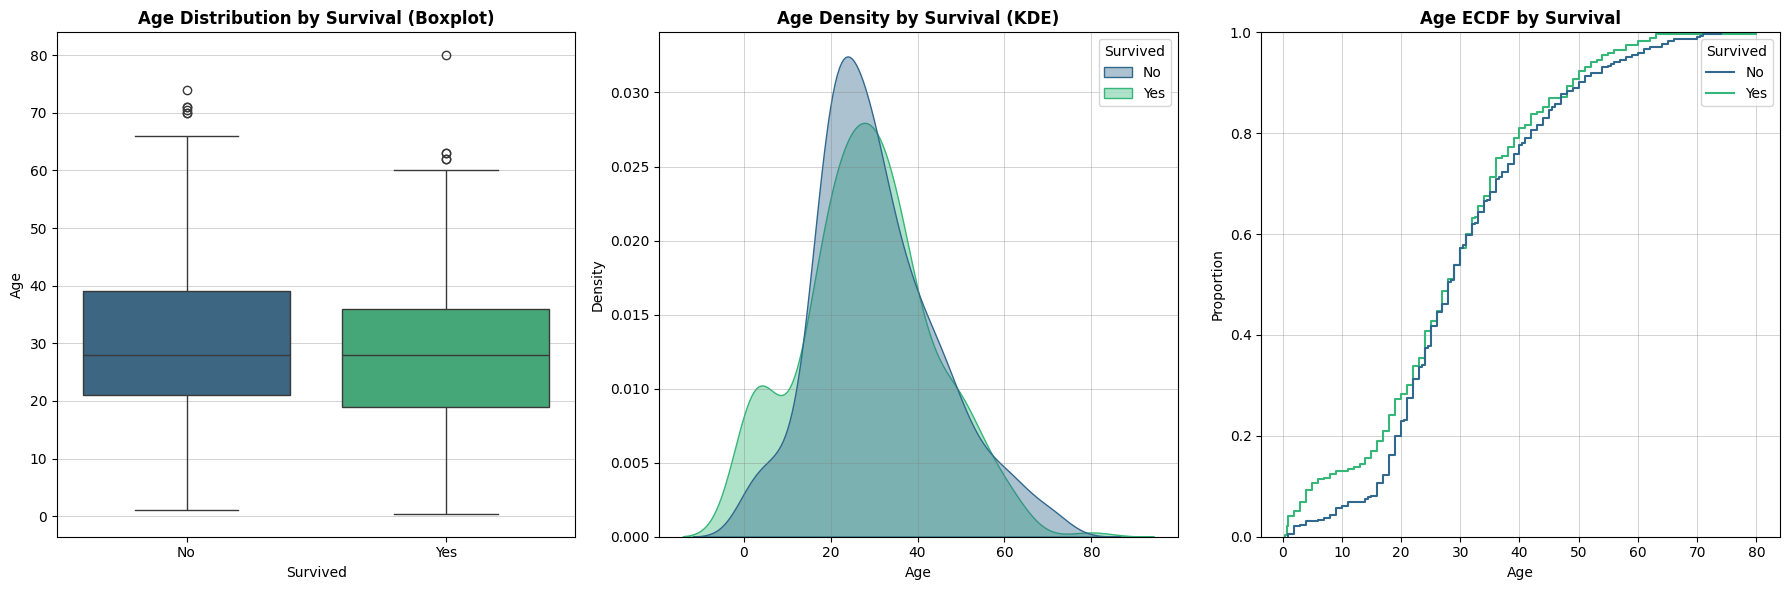

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 6))

# Boxplot: quartiles and outliers
sns.boxplot(data=train_eda, x="Survived", y="Age", palette="viridis", ax=ax1)
ax1.set(xlabel="Survived", ylabel="Age")
ax1.set_title("Age Distribution by Survival (Boxplot)", fontsize=12, fontweight="bold")
ax1.grid(True, axis="y", linewidth=0.6, alpha=0.4, color="grey")

# KDE: density shape (common_norm=False ensures each group integrates to 1)
sns.kdeplot(data=train_eda, x="Age", hue="Survived", palette="viridis", fill=True, common_norm=False, alpha=0.4, ax=ax2)
ax2.set(xlabel="Age", ylabel="Density")
ax2.set_title("Age Density by Survival (KDE)", fontsize=12, fontweight="bold")
ax2.grid(True, linewidth=0.6, alpha=0.4, color="grey")

# ECDF: cumulative proportions
sns.ecdfplot(data=train_eda, x="Age", hue="Survived", palette="viridis", ax=ax3)
ax3.set(xlabel="Age", ylabel="Proportion")
ax3.set_title("Age ECDF by Survival", fontsize=12, fontweight="bold")
ax3.grid(True, linewidth=0.6, alpha=0.4, color="grey")

plt.tight_layout()
plt.show()

### Age Distribution: Histogram and Strip Plot

Two complementary views of the Age variable by survival status:
- **Histogram** (left): density-normalised step histogram showing distributional overlap.
- **Strip plot** (right): individual observations with vertical jitter to reveal density clusters.

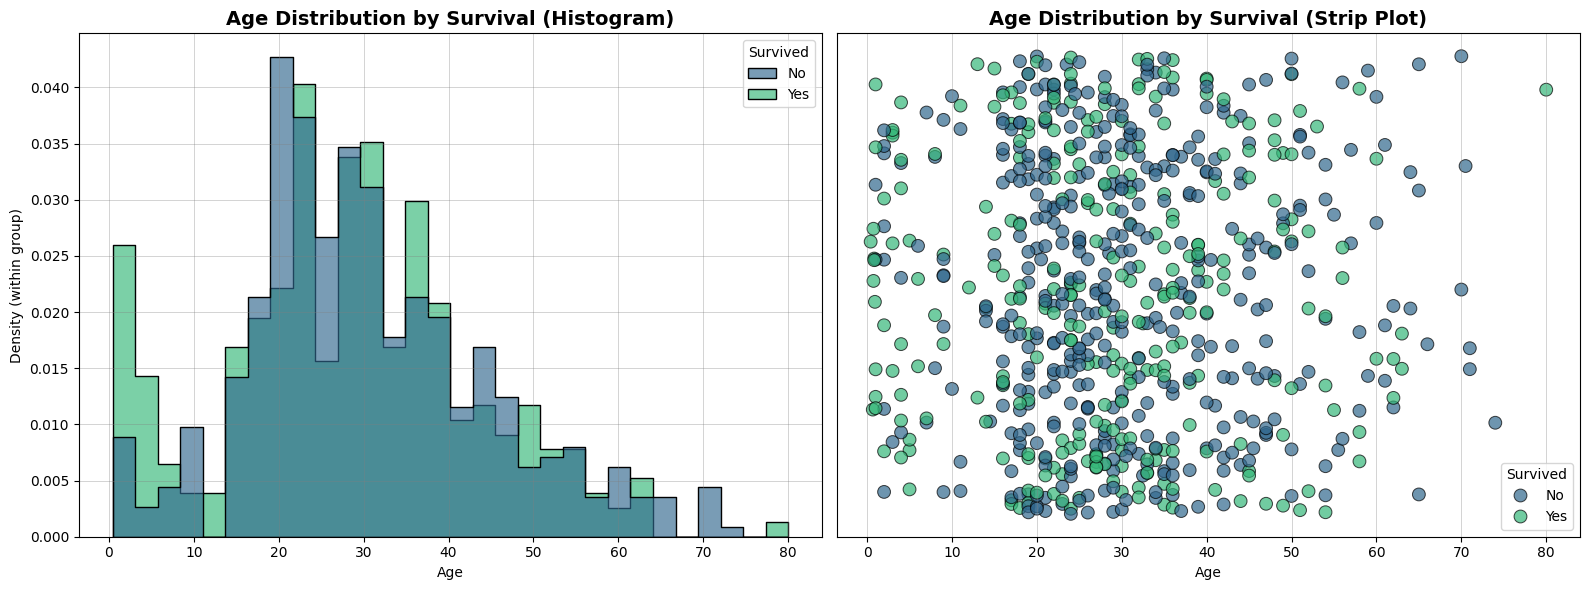

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: step histogram (density-normalised within each group)
sns.histplot(
	data=train_eda,
	x="Age",
	hue="Survived",
	palette="viridis",
	edgecolor="black",
	bins=30,
	stat="density",
	common_norm=False,
	element="step",
	alpha=0.65,
	ax=ax1,
)
ax1.set_title("Age Distribution by Survival (Histogram)", fontsize=14, fontweight="bold")
ax1.set(xlabel="Age", ylabel="Density (within group)")
ax1.grid(True, linewidth=0.6, alpha=0.4, color="grey")

# Right: jittered strip plot (reproducible jitter)
rng = np.random.default_rng(seed=42)
jitter_y = rng.uniform(0, 0.8, len(train_eda))

sns.scatterplot(
	data=train_eda,
	x="Age",
	y=jitter_y,
	hue="Survived",
	palette="viridis",
	edgecolor="black",
	s=85,
	alpha=0.7,
	ax=ax2,
)
ax2.set_title("Age Distribution by Survival (Strip Plot)", fontsize=14, fontweight="bold")
ax2.set(xlabel="Age", ylabel="")
ax2.set_yticks([])
ax2.grid(True, linewidth=0.6, alpha=0.4, color="grey")

plt.tight_layout()
plt.show()

> **Insight (Age)**: Age appears to play a modest role in survival prediction, with older passengers showing a slightly lower survival rate. However, the Age column contains 177 missing values (~20% of the dataset). Further investigation is required to determine an appropriate imputation strategy.

### Cabin Prefix: Frequency and Survival Patterns

We examine how passengers are distributed across cabin deck prefixes and whether the prefix correlates with survival.

In [13]:
# Frequency and survival rate by cabin prefix
cabin_stats = (
	train_eda.groupby("CabinCode", dropna=False).agg(count=("Survived", "size"), survival_rate=("Survived", lambda x: (x == "Yes").mean())).sort_values("count", ascending=False)
)
cabin_stats

,count,survival_rate
CabinCode,,
NaN,687,0.299854
C,59,0.593220
B,47,0.744681
D,33,0.757576
E,32,0.750000
A,15,0.466667
F,13,0.615385
G,4,0.500000
T,1,0.000000


### Survival by Cabin Deck Prefix

The cabin identifier's first letter typically indicates the deck (A = top deck, etc.). Missing cabin values appear as `NaN`. Note the small sample sizes for some decks.

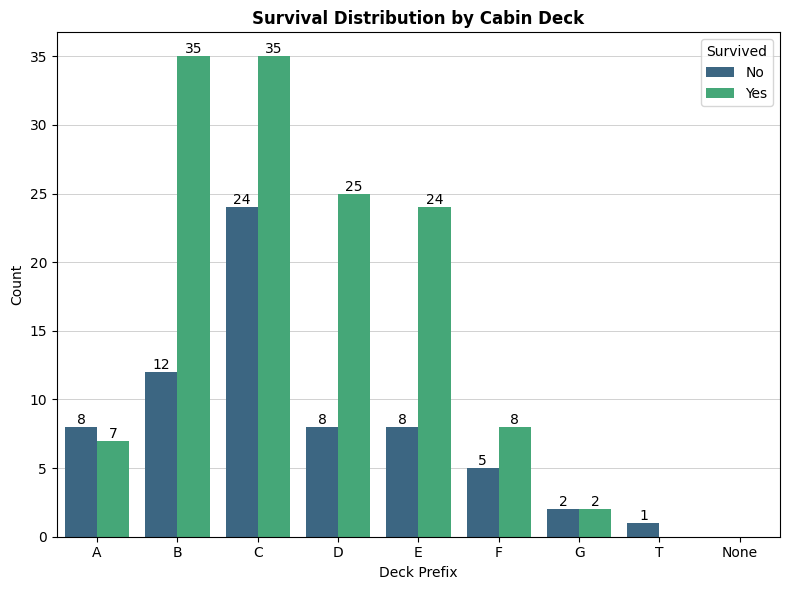

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))

# Order by deck letter (A-G, T, then NaN)
deck_order = ["A", "B", "C", "D", "E", "F", "G", "T", None]

sns.countplot(
	data=train_eda,
	x="CabinCode",
	hue="Survived",
	palette="viridis",
	order=[d for d in deck_order if d is None or d in train_eda["CabinCode"].values],
	ax=ax,
)

ax.set_title("Survival Distribution by Cabin Deck", fontsize=12, fontweight="bold")
ax.set(xlabel="Deck Prefix", ylabel="Count")
ax.grid(True, axis="y", alpha=0.5, linewidth=0.5, color="grey")
ax.set_axisbelow(True)

for container in ax.containers:
	ax.bar_label(container, fontsize=10)

plt.tight_layout()
plt.show()

### Investigating the Impact of Missing Values in the 'Cabin' Column: Assessing Whether Missingness Is Informative or Random

### Diagnosing Cabin Missingness: Informative or Random?

To determine whether the absence of cabin information is random (MCAR) or correlated with other features (MAR/MNAR), we compare survival distributions across key variables for passengers with and without cabin data.

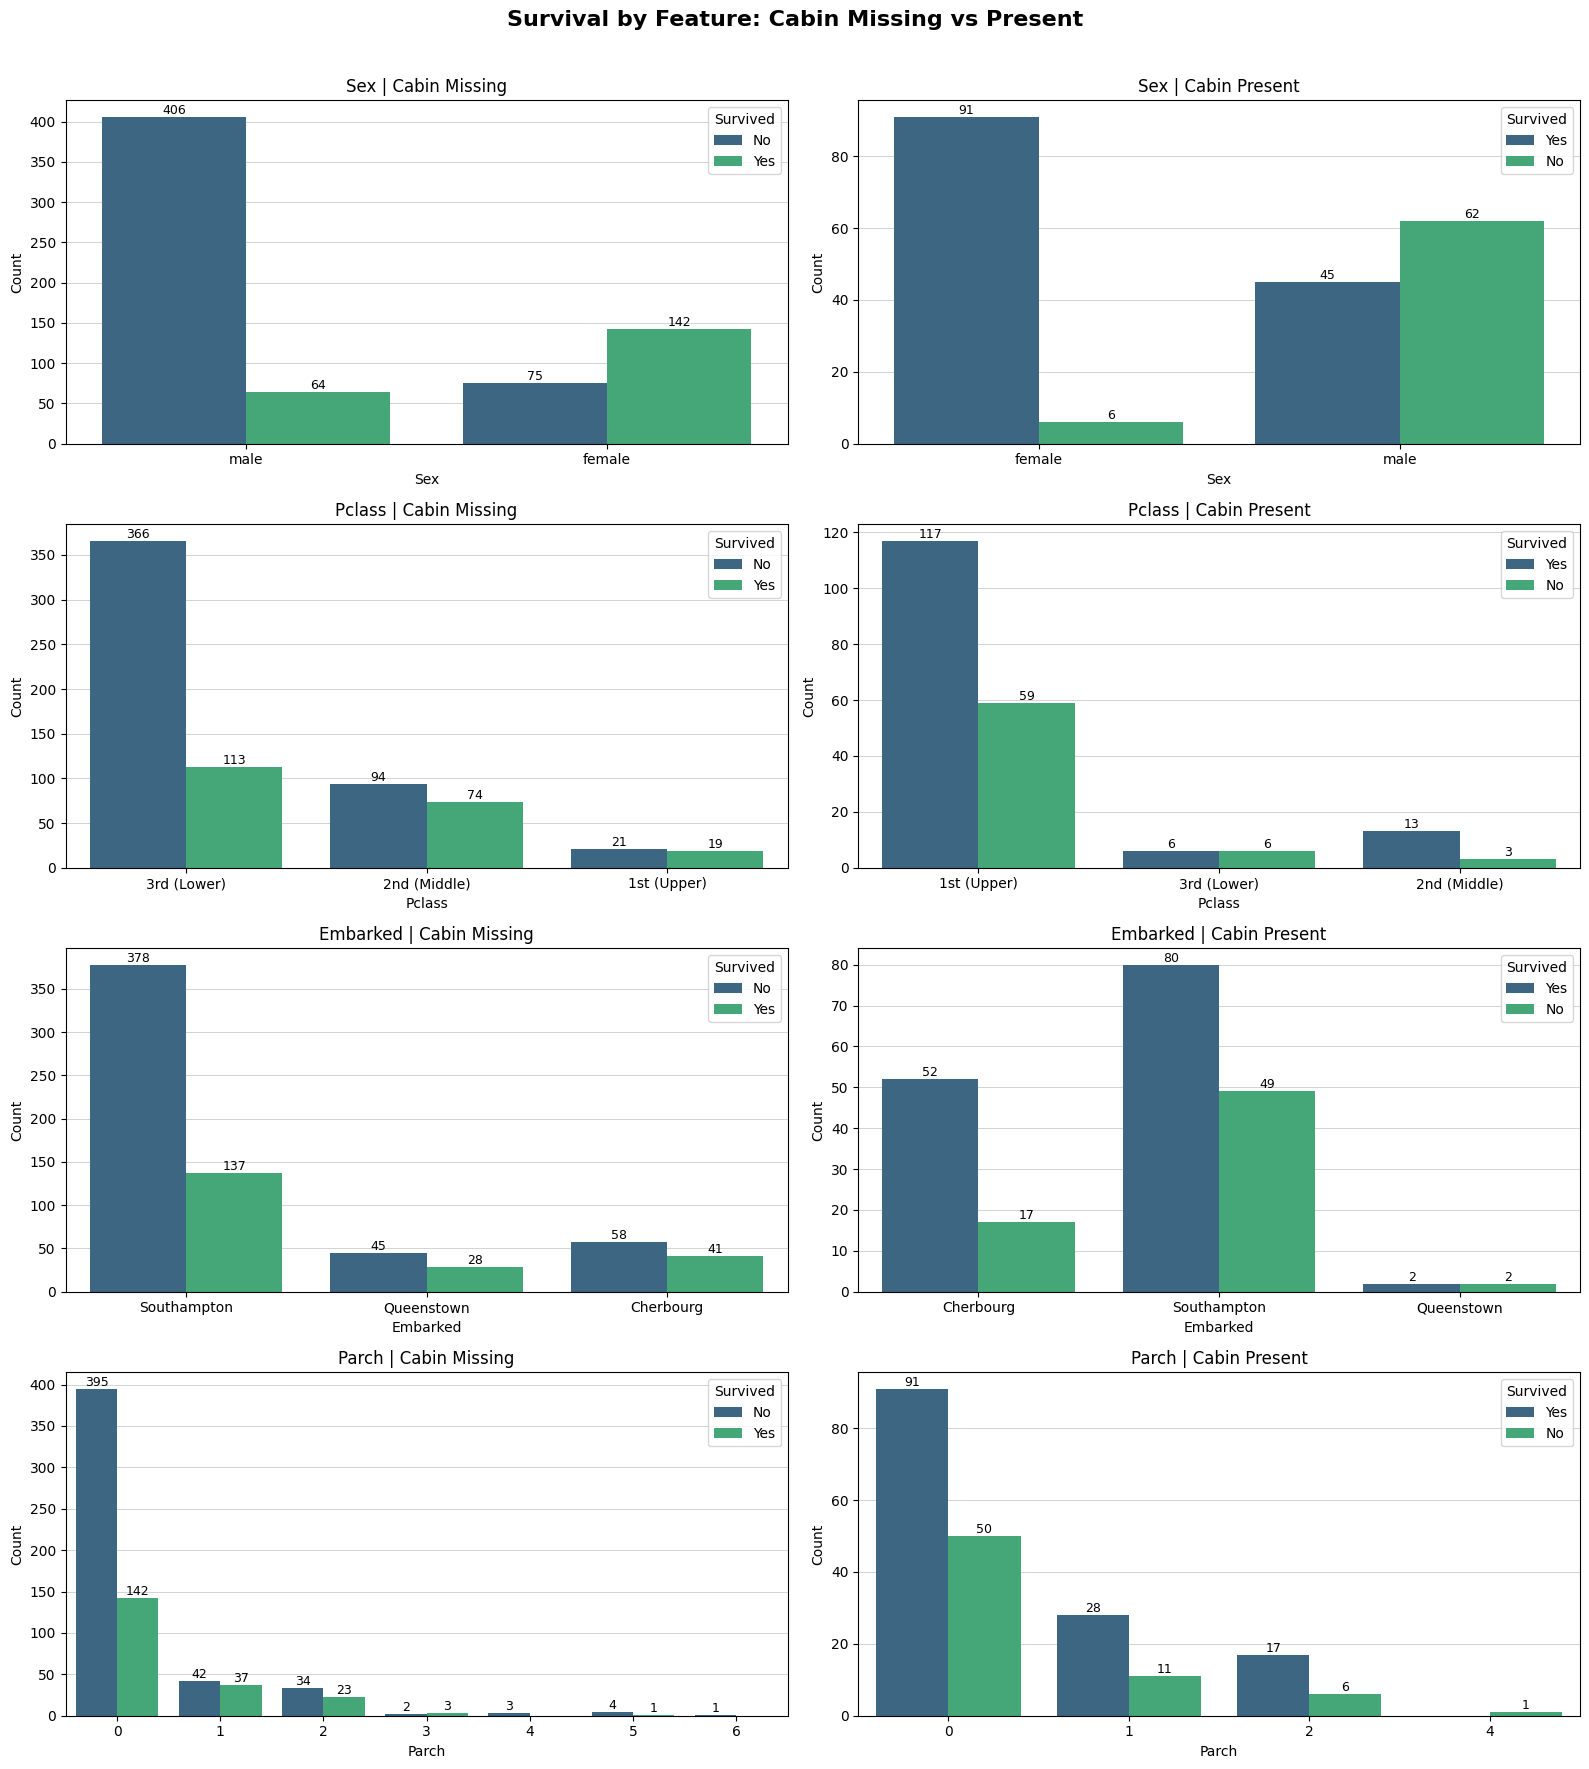

In [15]:
# Subset by cabin missingness
cabin_missing = train_eda.query("CabinMissing == 'Missing'")
cabin_present = train_eda.query("CabinMissing == 'Non-missing'")

cols_of_interest = ["Sex", "Pclass", "Embarked", "Parch"]

fig, axes = plt.subplots(nrows=len(cols_of_interest), ncols=2, figsize=(16, 18))

for i, col in enumerate(cols_of_interest):
	# Left: cabin missing
	ax_left = axes[i, 0]
	sns.countplot(data=cabin_missing, x=col, hue="Survived", palette="viridis", ax=ax_left)
	ax_left.set_title(f"{col} | Cabin Missing", fontsize=12)
	ax_left.set(xlabel=col, ylabel="Count")
	ax_left.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_left.set_axisbelow(True)
	for container in ax_left.containers:
		ax_left.bar_label(container, fontsize=9)

	# Right: cabin present
	ax_right = axes[i, 1]
	sns.countplot(data=cabin_present, x=col, hue="Survived", palette="viridis", ax=ax_right)
	ax_right.set_title(f"{col} | Cabin Present", fontsize=12)
	ax_right.set(xlabel=col, ylabel="Count")
	ax_right.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_right.set_axisbelow(True)
	for container in ax_right.containers:
		ax_right.bar_label(container, fontsize=9)

plt.suptitle(
	"Survival by Feature: Cabin Missing vs Present",
	fontsize=16,
	fontweight="bold",
)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

> **Insight (Cabin)**: The Cabin column has 687 missing values (77% of the dataset). Missingness is clearly *not* random: passengers in first class are far more likely to have a recorded cabin number than those in third class, indicating correlation with socio-economic status. Rather than dropping the column, we engineer two features:
> 1. **CabinMissing**: binary indicator for whether cabin data exists.
> 2. **CabinCode**: the deck prefix (first letter), where available.
>
> Both may carry predictive signal.

### Diagnosing Age Missingness: Informative or Random?

We apply the same diagnostic approach used for Cabin: compare survival distributions across key features for passengers with and without recorded Age values.

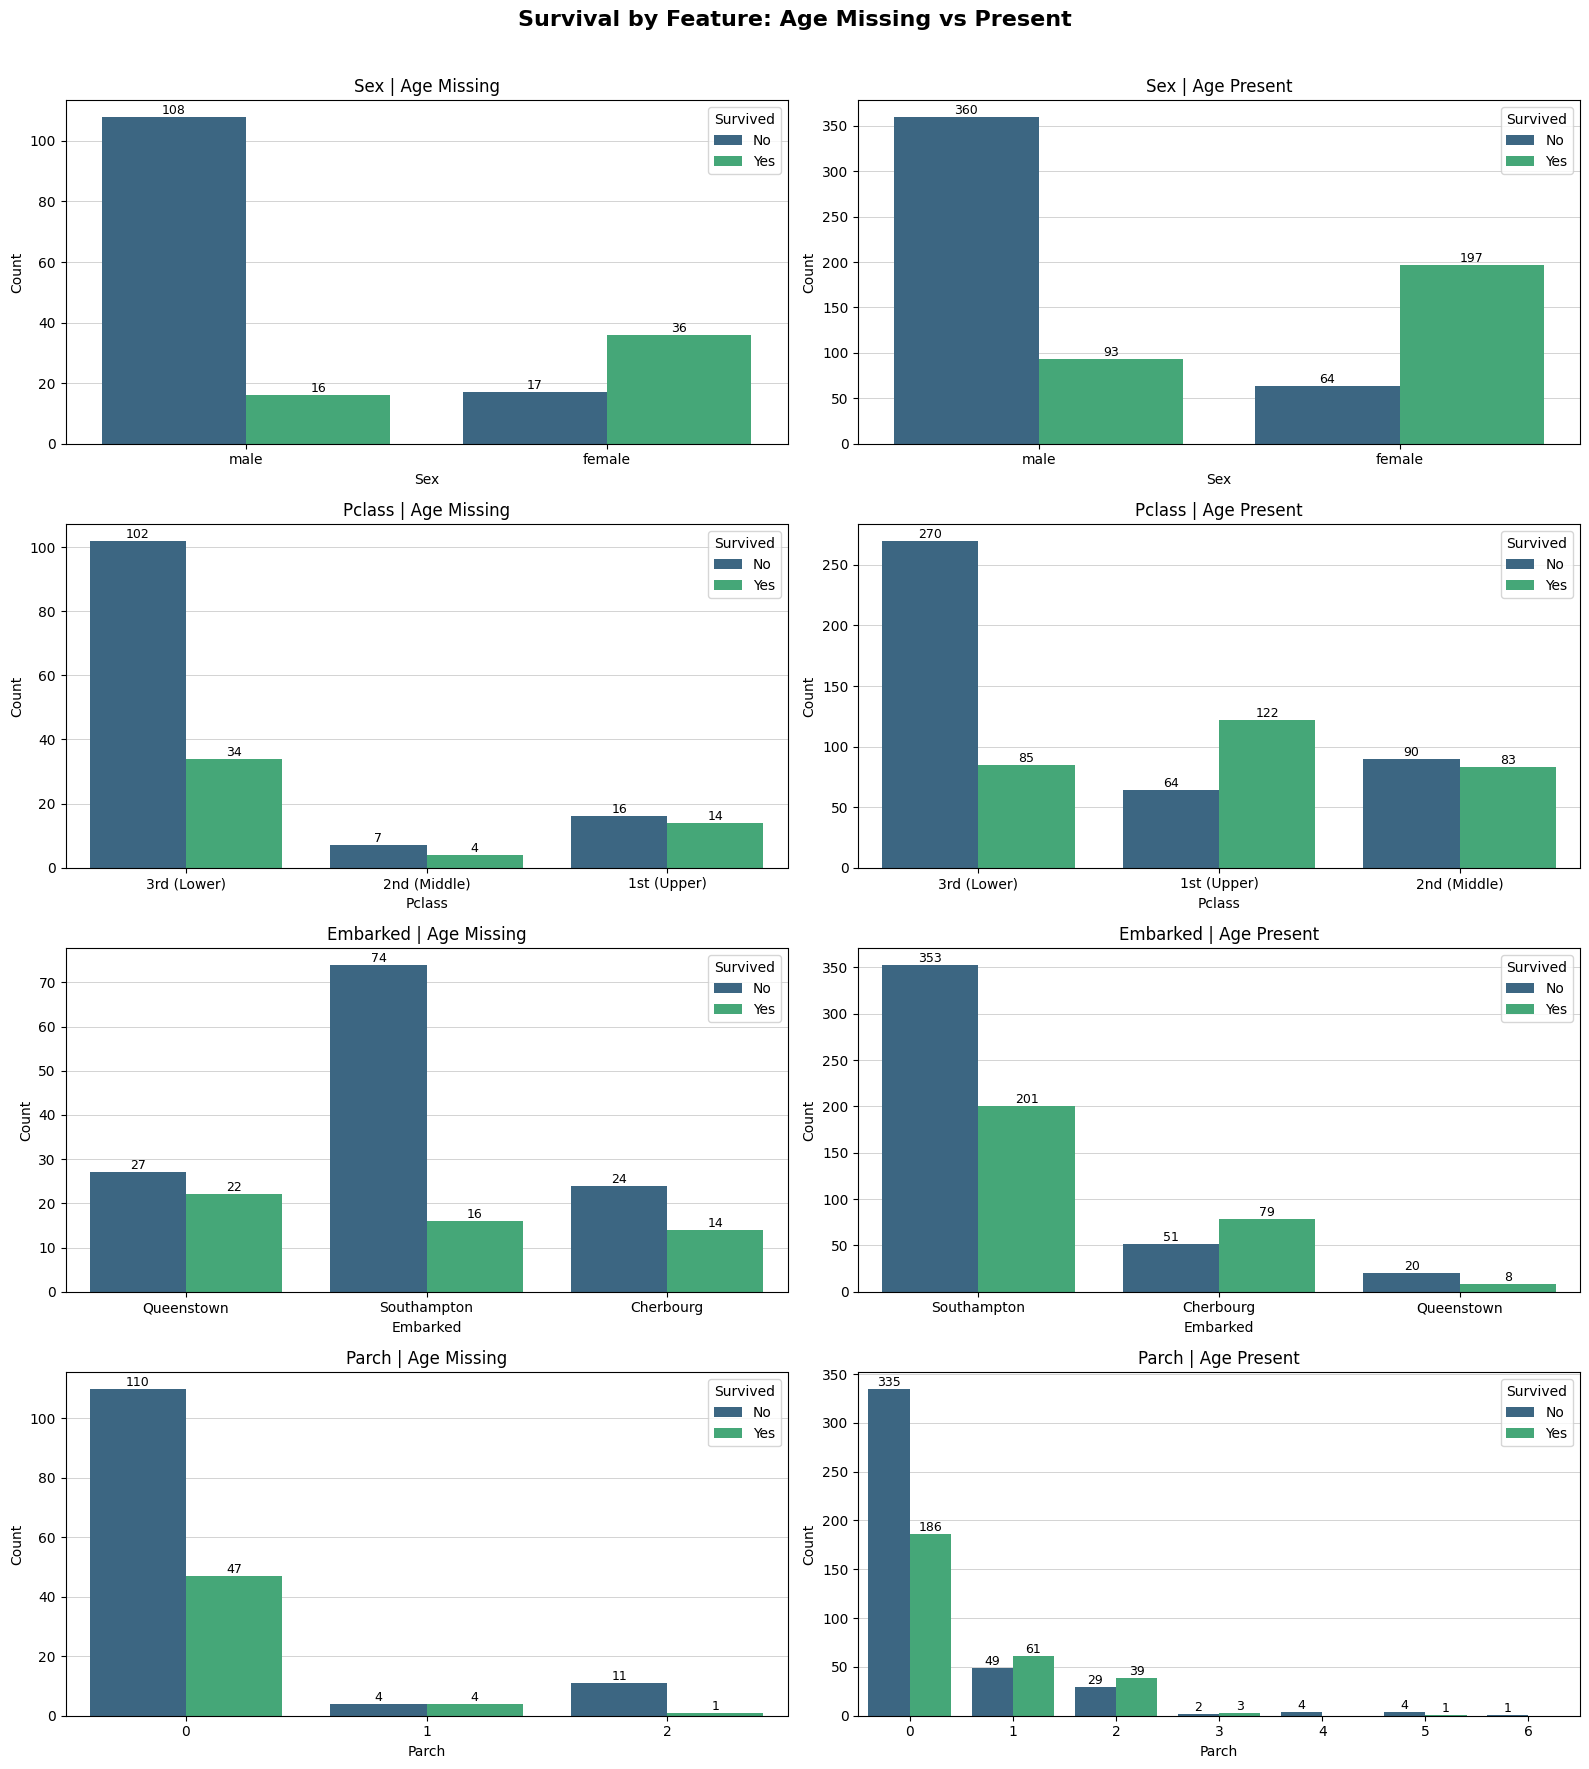

In [16]:
# Subset by age missingness
age_missing = train_eda.query("AgeMissing == 'Missing'")
age_present = train_eda.query("AgeMissing == 'Non-missing'")

cols_of_interest = ["Sex", "Pclass", "Embarked", "Parch"]

fig, axes = plt.subplots(nrows=len(cols_of_interest), ncols=2, figsize=(16, 18))

for i, col in enumerate(cols_of_interest):
	# Left: age missing
	ax_left = axes[i, 0]
	sns.countplot(data=age_missing, x=col, hue="Survived", palette="viridis", ax=ax_left)
	ax_left.set_title(f"{col} | Age Missing", fontsize=12)
	ax_left.set(xlabel=col, ylabel="Count")
	ax_left.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_left.set_axisbelow(True)
	for container in ax_left.containers:
		ax_left.bar_label(container, fontsize=9)

	# Right: age present
	ax_right = axes[i, 1]
	sns.countplot(data=age_present, x=col, hue="Survived", palette="viridis", ax=ax_right)
	ax_right.set_title(f"{col} | Age Present", fontsize=12)
	ax_right.set(xlabel=col, ylabel="Count")
	ax_right.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
	ax_right.set_axisbelow(True)
	for container in ax_right.containers:
		ax_right.bar_label(container, fontsize=9)

plt.suptitle("Survival by Feature: Age Missing vs Present", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

> **Insight (Age)**: Unlike Cabin, Age missingness does not show strong systematic patterns across Sex, Pclass, or Embarked. This suggests the data may be closer to MCAR (missing completely at random). We will impute missing Age values using the **median Age grouped by Pclass and Sex**, a common approach that leverages available structure without introducing complex assumptions.

### Investigating Missing Embarked Values

Only two passengers have missing Embarked values. We attempt to infer the correct port by:
1. Inspecting the passengers' other attributes (Fare, Cabin, Pclass).
2. Comparing with passengers of similar characteristics.
3. Checking fare distributions by embarkation port for first-class passengers.

In [17]:
# Identify passengers with missing Embarked
missing_embarked = train_eda[train_eda["Embarked"].isna()]
display(missing_embarked)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinCode,CabinMissing,AgeMissing
61,62,Yes,1st (Upper),"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,B,Non-missing,Non-missing
829,830,Yes,1st (Upper),"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,B,Non-missing,Non-missing


In [18]:
# Find similar passengers: same cabin deck (B), comparable fare (~$80)
display(train_eda.query("Fare >= 80.0 and Fare <= 150.0 and CabinCode == 'B'"))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,CabinCode,CabinMissing,AgeMissing
31,32,Yes,1st (Upper),"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,Cherbourg,B,Non-missing,Missing
61,62,Yes,1st (Upper),"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN,B,Non-missing,Non-missing
195,196,Yes,1st (Upper),"Lurette, Miss. Elise",female,58.0,0,0,PC 17569,146.5208,B80,Cherbourg,B,Non-missing,Non-missing
257,258,Yes,1st (Upper),"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5000,B77,Southampton,B,Non-missing,Non-missing
291,292,Yes,1st (Upper),"Bishop, Mrs. Dickinson H (Helen Walton)",female,19.0,1,0,11967,91.0792,B49,Cherbourg,B,Non-missing,Non-missing
390,391,Yes,1st (Upper),"Carter, Mr. William Ernest",male,36.0,1,2,113760,120.0000,B96 B98,Southampton,B,Non-missing,Non-missing
435,436,Yes,1st (Upper),"Carter, Miss. Lucile Polk",female,14.0,1,2,113760,120.0000,B96 B98,Southampton,B,Non-missing,Non-missing
484,485,Yes,1st (Upper),"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,Cherbourg,B,Non-missing,Non-missing
504,505,Yes,1st (Upper),"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5000,B79,Southampton,B,Non-missing,Non-missing
520,521,Yes,1st (Upper),"Perreault, Miss. Anne",female,30.0,0,0,12749,93.5000,B73,Southampton,B,Non-missing,Non-missing


In [19]:
# Fare distribution by Embarked for first-class passengers
train_eda.query("Pclass == '1st (Upper)'").groupby("Embarked")["Fare"].describe()

,count,mean,std,min,25%,50%,75%,max
Embarked,,,,,,,,
Cherbourg,85.0,104.718529,99.093935,26.55,49.50,78.2667,110.8833,512.3292
Queenstown,2.0,90.000000,0.000000,90.00,90.00,90.0000,90.0000,90.0000
Southampton,127.0,70.364862,58.811278,0.00,29.25,52.0000,83.4750,263.0000


> **Insight (Embarked)**: Only two passengers have missing Embarked values. Data-driven inference was inconclusive: their fare and cabin characteristics were consistent with multiple ports. However, historical records confirm both passengers (including Amelia Icard) boarded at **Southampton**. We impute both missing values as "S".
>
> Source: [Encyclopedia Titanica](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html)

### Exploring the Possibility of Feature Engineering with the 'Name' Column

In [20]:
title_mapping = {
	"Mlle": "Miss",
	"Ms": "Miss",
	"Mme": "Mrs",
	"Lady": "Rare_Title",
	"Countess": "Rare_Title",
	"Dona": "Rare_Title",
	"Sir": "Rare_Title",
	"Don": "Rare_Title",
	"Jonkheer": "Rare_Title",
	"Col": "Rare_Title",
	"Major": "Rare_Title",
	"Capt": "Military",
	"Rev": "Rare_Title",
	"Dr": "Rare_Title",
}

In [21]:
# Apply title mapping to standardize title categories
train_eda["Title"] = train_eda["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
train_eda["Title"] = train_eda["Title"].replace(title_mapping)

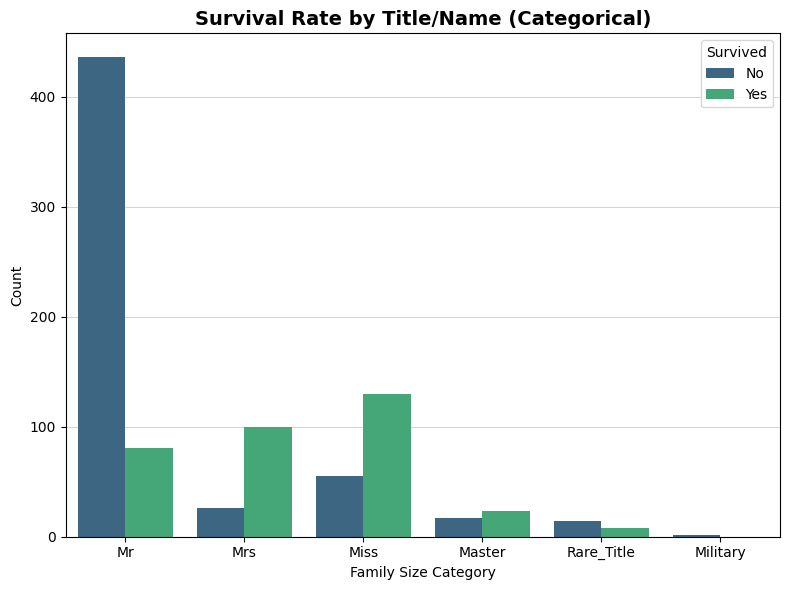

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

# Left plot: Categorical family size
sns.countplot(data=train_eda, x="Title", hue="Survived", palette="viridis", ax=ax)
ax.set_title("Survival Rate by Title/Name (Categorical)", fontsize=14, fontweight="bold")
ax.set(xlabel="Family Size Category", ylabel="Count")
ax.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
ax.set_axisbelow(True)
ax.legend(title="Survived", labels=["No", "Yes"])


plt.tight_layout()
plt.show()

> The 'Title' extracted from the 'Name' column can provide valuable insights into social status, age group, and gender, which may influence survival outcomes. By categorizing titles into broader groups (e.g., 'Mr', 'Mrs', 'Miss', 'Master', 'Other'), we can create a new feature that captures these social distinctions.

### Exploring the possibility of Feature Engineering with 'Family Size' derived from 'SibSp' and 'Parch' columns

In [23]:
# Family size
train_eda["FamilySize"] = train_eda["SibSp"] + train_eda["Parch"]
train_eda["FamilyCat"] = pd.cut(train_eda["FamilySize"], bins=[0, 1, 4, np.inf], labels=["Alone", "Small", "Large"], right=False)

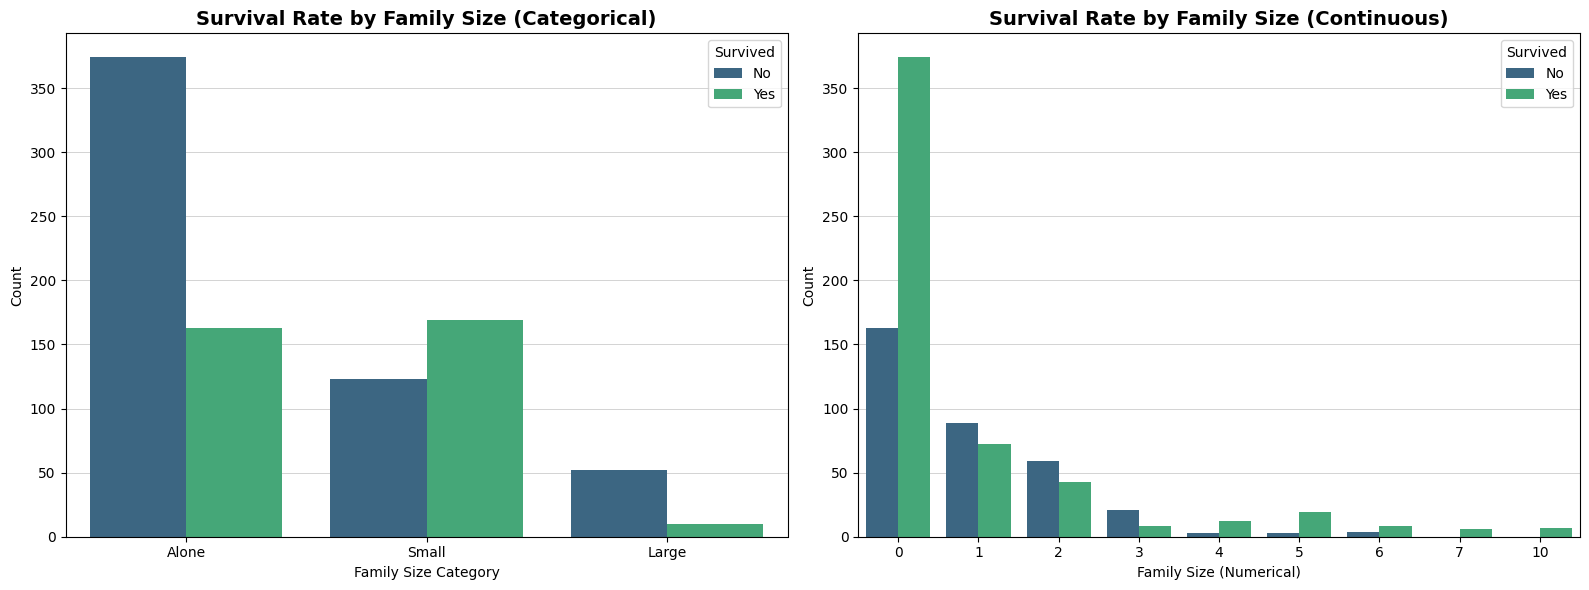

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Categorical family size
sns.countplot(data=train_eda, x="FamilyCat", hue="Survived", palette="viridis", ax=ax1)
ax1.set_title("Survival Rate by Family Size (Categorical)", fontsize=14, fontweight="bold")
ax1.set(xlabel="Family Size Category", ylabel="Count")
ax1.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
ax1.set_axisbelow(True)
ax1.legend(title="Survived", labels=["No", "Yes"])

# Right plot: Continuous family size
sns.countplot(data=train_eda, x="FamilySize", hue="Survived", palette="viridis", ax=ax2)
ax2.set_title("Survival Rate by Family Size (Continuous)", fontsize=14, fontweight="bold")
ax2.set(xlabel="Family Size (Numerical)", ylabel="Count")
ax2.grid(True, axis="y", alpha=0.4, linewidth=0.6, color="grey")
ax2.set_axisbelow(True)
ax2.legend(title="Survived", labels=["No", "Yes"])

plt.tight_layout()
plt.show()

> The columns 'SibSp' (number of siblings/spouses aboard) and 'Parch' (number of parents/children aboard) can be combined to create a new feature called 'FamilySize'. This feature represents the total number of family members traveling together, which may influence survival chances. Additionally, we can derive together some categorical features referring to the 'bins' of FamilySize, such as 'Alone' (FamilySize = 1), 'Small' (FamilySize = 2-4), and 'Large' (FamilySize >= 5).

### Applying Imputation to the EDA Dataframe

Before concluding EDA, we apply the imputation strategies developed above to `train_eda`. This allows any remaining exploratory analysis to use complete data.

**Note**: These transformations are applied only to `train_eda`. The modelling pipeline will implement equivalent logic on the raw data (`train_raw`) to ensure proper separation of train/test and avoid data leakage.

In [25]:
# Impute missing Age using median grouped by Pclass and Sex
train_eda["Age"] = train_eda.groupby(["Pclass", "Sex"])["Age"].transform(lambda x: x.fillna(x.median()))

# Impute missing CabinCode as 'Unknown'
train_eda["CabinCode"] = train_eda["CabinCode"].fillna("Unknown")

# Impute missing Embarked as 'Southampton' (verified via historical records)
train_eda["Embarked"] = train_eda["Embarked"].fillna("Southampton")

## Train/Test Split

We split the original (unmapped) data into training and test sets. Key decisions:
- **Stratified split**: preserves the class distribution of `Survived` in both sets.
- **Hold-out ratio**: 80% train, 20% test.
- **Excluded columns**: `PassengerId` (identifier only), `Survived` (target).

Columns like `Name`, `Ticket`, and `Cabin` are excluded from the initial column lists; they will be handled by custom transformers in the pipeline.

In [26]:
# Use the original (unmapped) data for modelling
X = train.drop(columns=["PassengerId", "Survived"])
y = train["Survived"]

X_train, X_test, y_train, y_test = train_test_split(
	X, y,
	test_size=0.2,
	stratify=y,
	random_state=42,
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)}")

Train size: 712 | Test size: 179


In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 692 to 507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Name      712 non-null    object 
 2   Sex       712 non-null    object 
 3   Age       575 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Ticket    712 non-null    object 
 7   Fare      712 non-null    float64
 8   Cabin     160 non-null    object 
 9   Embarked  710 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 61.2+ KB


In [28]:
num_cols = ["Age", "Fare", "SibSp", "Parch"]
cat_cols = ["Pclass", "Sex", "Embarked"]

## Helper Functions

### Classification Evaluation (Visual)

`classification_evaluation` performs K-fold cross-validation on an unfitted estimator and produces a 3-panel diagnostic figure:

1. **Mean Confusion Matrix** (row-normalised, with ±1 std).
2. **Mean ROC Curve** with AUC and uncertainty band.
3. **Mean Precision-Recall Curve** with AP and baseline prevalence.

This function is designed for binary classification and requires the estimator to implement `predict_proba()`.

In [29]:
def classification_evaluation(
	X: pd.DataFrame | ArrayLike,
	y: ArrayLike,
	estimator: BaseEstimator,
	*,
	cv: int = 5,
	threshold: float | None = None,
	random_state: int = 42,
) -> dict[str, float]:
	"""
	Evaluate binary classification using cross-validation.

	Parameters
	----------
	X : DataFrame or array-like
		Feature matrix.
	y : array-like
		True labels.
	estimator : BaseEstimator
		Unfitted scikit-learn estimator (cloned for each fold).
	cv : int, default=5
		Number of cross-validation folds.
	threshold : float or None, default=None
		Probability threshold for class assignment. If None, uses
		estimator.predict().
	random_state : int, default=42
		Random state for reproducibility.

	Returns
	-------
	dict[str, float]
		Dictionary with mean_auc, std_auc, mean_ap, std_ap.
	"""

	if not isinstance(y, (np.ndarray, pd.DataFrame, pd.Series, list)):
		raise TypeError(f"y must be array-like, got {type(y).__name__}")

	if not isinstance(X, (np.ndarray, pd.DataFrame)):
		raise TypeError(f"X must be either an Array or a DataFrame, got {type(X).__name__}")

	if not isinstance(estimator, BaseEstimator):
		raise TypeError(f"estimator must be a Scikit-Learn Estimator, got {type(estimator).__name__}")

	if threshold is not None:
		if not isinstance(threshold, (int, float)):
			raise TypeError(f"threshold must be a float in [0, 1] or None, got {type(threshold).__name__}")
		if not (0.0 <= float(threshold) <= 1.0):
			raise ValueError(f"threshold must be in [0, 1], got {threshold}")

	y_array = np.asarray(y)

	fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

	# Initialize containers for CV results
	cms: list[np.ndarray] = []
	tprs: list[np.ndarray] = []
	aucs: list[float] = []
	precisions_list: list[np.ndarray] = []
	aps: list[float] = []

	# Common interpolation points
	mean_fpr = np.linspace(0, 1, 100)
	mean_recall = np.linspace(0, 1, 100)

	# Perform cross-validation
	skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)

	# Track unknown categories across folds
	unknown_category_columns: set[int] = set()

	# Custom warning filter
	with warnings.catch_warnings(record=True) as caught_warnings:
		warnings.filterwarnings("always", category=UserWarning, module="sklearn")

		for train_idx, val_idx in skf.split(X, y_array):
			# Split data
			if isinstance(X, pd.DataFrame):
				X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
			else:
				X_train, X_val = X[train_idx], X[val_idx]

			y_train, y_val = y_array[train_idx], y_array[val_idx]

			# Clone and fit estimator
			fold_estimator = clone(estimator)
			fold_estimator.fit(X_train, y_train)

			# Probability scores (needed for ROC/PR, and for thresholded predictions)
			if not hasattr(fold_estimator, "predict_proba"):
				raise TypeError("This evaluator requires predict_proba(). Your estimator does not implement it.")

			y_proba = fold_estimator.predict_proba(X_val)[:, 1]

			# Class predictions
			if threshold is None:
				y_pred = fold_estimator.predict(X_val)
			else:
				y_pred = (y_proba >= float(threshold)).astype(int)

			# Confusion matrix (normalised)
			cm = confusion_matrix(y_true=y_val, y_pred=y_pred, normalize="true")
			cms.append(cm)

			# ROC curve
			fpr, tpr, _ = roc_curve(y_true=y_val, y_score=y_proba)
			roc_auc = roc_auc_score(y_true=y_val, y_score=y_proba)

			interp_tpr = np.interp(mean_fpr, fpr, tpr)
			interp_tpr[0] = 0.0
			tprs.append(interp_tpr)
			aucs.append(float(roc_auc))

			# Precision-Recall curve
			precision, recall, _ = precision_recall_curve(y_true=y_val, y_score=y_proba)
			avg_precision = average_precision_score(y_true=y_val, y_score=y_proba)

			# Interpolate precision
			interp_precision = np.interp(mean_recall, recall[::-1], precision[::-1])
			precisions_list.append(interp_precision)
			aps.append(float(avg_precision))

		# Process warnings
		for warning in caught_warnings:
			message = str(warning.message).lower()
			if "unknown categories" in message:
				match = re.search(r"columns \[([^\]]+)\]", str(warning.message))
				if match:
					cols = match.group(1).split(",")
					unknown_category_columns.update([int(c.strip()) for c in cols])

	# Display custom warning if unknown categories were found
	if unknown_category_columns:
		cols_list = sorted(list(unknown_category_columns))
		print(f"Unknown categories found in columns {cols_list} will be encoded as zeros.")

	# Mean Confusion Matrix
	mean_cm = np.mean(cms, axis=0)
	std_cm = np.std(cms, axis=0)

	# Create annotation labels with mean ± std
	annot_labels = np.array([[f"{mean_cm[row, col]:.1%}\n(±{std_cm[row, col]:.1%})" for col in range(2)] for row in range(2)])

	cm_df = pd.DataFrame(
		data=mean_cm,
		index=["Actual Negative", "Actual Positive"],
		columns=["Pred Negative", "Pred Positive"],
	)

	sns.heatmap(
		data=cm_df,
		annot=annot_labels,
		fmt="",
		cmap="Blues",
		cbar_kws={"label": "Proportion"},
		ax=axes[0],
		vmin=0,
		vmax=1,
	)
	axes[0].set_title(f"Mean Confusion Matrix\n({cv}-Fold CV, Row-Normalised)", fontsize=11, pad=9)
	axes[0].set_xlabel("Predicted Label")
	axes[0].set_ylabel("True Label")

	# Mean ROC Curve
	mean_tpr = np.mean(tprs, axis=0)
	mean_tpr[-1] = 1.0
	std_tpr = np.std(tprs, axis=0)
	mean_auc = float(np.mean(aucs))
	std_auc = float(np.std(aucs))

	axes[1].plot(
		mean_fpr,
		mean_tpr,
		color="darkorange",
		linewidth=2.5,
		label=f"Mean ROC (AUC = {mean_auc:.3f} ± {std_auc:.3f})",
	)

	axes[1].fill_between(
		mean_fpr,
		np.maximum(mean_tpr - std_tpr, 0),
		np.minimum(mean_tpr + std_tpr, 1),
		color="darkorange",
		alpha=0.2,
		label="± 1 std. dev.",
	)

	axes[1].plot(
		[0, 1],
		[0, 1],
		color="navy",
		linestyle="--",
		alpha=0.5,
		label="Chance (AUC = 0.5)",
	)
	axes[1].set_title(f"Mean ROC Curve ({cv}-Fold CV)", fontsize=11, pad=9)
	axes[1].set_xlabel("False Positive Rate (1 - Specificity)")
	axes[1].set_ylabel("True Positive Rate (Sensitivity)")
	axes[1].set_xlim([-0.02, 1.02])
	axes[1].set_ylim([-0.02, 1.02])
	axes[1].legend(loc="lower right", frameon=True, fancybox=True, shadow=True)
	axes[1].grid(True, alpha=0.4, linewidth=0.4, color="grey")

	# Mean Precision-Recall Curve
	mean_precision = np.mean(precisions_list, axis=0)
	std_precision = np.std(precisions_list, axis=0)
	mean_ap = float(np.mean(aps))
	std_ap = float(np.std(aps))

	axes[2].plot(
		mean_recall,
		mean_precision,
		color="forestgreen",
		linewidth=2.5,
		label=f"Mean PR (AP = {mean_ap:.3f} ± {std_ap:.3f})",
	)

	axes[2].fill_between(
		mean_recall,
		np.maximum(mean_precision - std_precision, 0),
		np.minimum(mean_precision + std_precision, 1),
		color="forestgreen",
		alpha=0.2,
		label="± 1 std. dev.",
	)

	# Baseline prevalence
	baseline = float(np.mean(y_array))
	axes[2].axhline(
		y=baseline,
		color="dimgrey",
		linestyle="--",
		linewidth=2,
		alpha=0.7,
		label=f"Baseline (Prevalence = {baseline:.3f})",
	)

	axes[2].set_title(f"Mean Precision-Recall Curve ({cv}-Fold CV)", fontsize=11, pad=9)
	axes[2].set_xlabel("Recall (Sensitivity)")
	axes[2].set_ylabel("Precision (PPV)")
	axes[2].set_xlim([-0.02, 1.02])
	axes[2].set_ylim([0.0, 1.05])
	axes[2].legend(loc="best", frameon=True, fancybox=True, shadow=True)
	axes[2].grid(True, alpha=0.4, linewidth=0.4, color="grey")

	# Extract model name
	if hasattr(estimator, "named_steps") and "model" in estimator.named_steps:
		model_name = estimator.named_steps["model"].__class__.__name__
	elif hasattr(estimator, "steps"):
		model_name = estimator.steps[-1][1].__class__.__name__
	else:
		model_name = estimator.__class__.__name__

	threshold_text = "" if threshold is None else f" | threshold={float(threshold):.2f}"
	plt.suptitle(
		f"Binary Classification: {model_name} ({cv}-Fold Cross-Validation){threshold_text}",
		fontsize=14,
		fontweight="bold",
	)
	plt.tight_layout()
	plt.show()

	return {
		"mean_auc": mean_auc,
		"std_auc": std_auc,
		"mean_ap": mean_ap,
		"std_ap": std_ap,
	}


### Candidate Comparison (Tabular Metrics)

`evaluate_candidates` cross-validates a dictionary of candidate estimators on identical stratified folds and returns a summary DataFrame with mean and std for each metric.

**Usage**:
```python
results = evaluate_candidates(
candidates={"LogReg": pipe_lr, "RF": pipe_rf},
			X=X_train,
			y=y_train,
			sort_by="roc_auc",
)
```

In [30]:
SortMetric = Literal["accuracy", "f1", "roc_auc"]


def evaluate_candidates(
	candidates: dict[str, BaseEstimator],
	X: pd.DataFrame | ArrayLike,
	y: ArrayLike,
	*,
	n_splits: int = 5,
	sort_by: SortMetric = "roc_auc",
	n_jobs: int = -1,
	random_state: int = 42,  # Expose this
	verbose: bool = True,
	return_train_score: bool = False,
	error_score: float | int | str = np.nan,
) -> pd.DataFrame:
	"""
	Cross-validate a set of candidate estimators/pipelines on the same splits and
	return a sorted summary table.

	Notes:
	- Uses StratifiedKFold (appropriate for classification like Titanic).
	- Computes mean and std for each metric across folds.
	"""
	cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
	scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

	results_list: list[dict[str, object]] = []

	for name, model in candidates.items():
		if verbose:
			print(f"Evaluating {name}...")

		cv_results = cross_validate(
			model,
			X,
			y,
			cv=cv,
			scoring=scoring,
			n_jobs=n_jobs,
			return_train_score=return_train_score,
			error_score=error_score,
		)

		row: dict[str, object] = {"Model": name}

		for key, scores in cv_results.items():
			if key.endswith("_time"):
				continue

			scores_array = np.asarray(scores, dtype=float)
			row[f"{key} (mean)"] = float(np.nanmean(scores_array))
			row[f"{key} (std)"] = float(np.nanstd(scores_array, ddof=0))

		results_list.append(row)

	df = pd.DataFrame(results_list)

	sort_col = f"test_{sort_by} (mean)"
	if sort_col not in df.columns:
		# Fallback if something went wrong or metric missing
		available = [c for c in df.columns if c.startswith("test_") and c.endswith("(mean)")]
		sort_col = available[0] if available else df.columns[0]

	return df.sort_values(sort_col, ascending=False).reset_index(drop=True)

## Pipeline Factory and Custom Transformers

This section defines reusable sklearn-compatible transformers for feature engineering and a factory function to assemble the full modelling pipeline.

### Design Principles

1. **Single responsibility**: each transformer handles one logical task.
2. **Stateless transforms where possible**: transformers that don't learn from data (e.g., `CodeExtractor`) still follow the fit/transform API for pipeline compatibility.
3. **Defensive coding**: type checks, missing column checks, and informative errors.
4. **Leakage prevention**: imputation parameters (e.g., group medians) are learned only from training data during `fit()`.

### Custom Transformers

| Transformer | Purpose |
|-------------|---------|
| `ValueDecoder` | Map categorical codes to readable labels; extract Title from Name |
| `CodeExtractor` | Extract cabin deck prefix from Cabin column |
| `MissingIndicatorFeatures` | Create binary indicators for missing values |
| `FamilyFeatures` | Engineer FamilySize, Alone, and FamilyCat from SibSp/Parch |
| `GroupMedianImputer` | Impute missing values using group medians with global fallback |

In [31]:
from typing import Sequence

from sklearn.utils.validation import check_is_fitted


class ValueDecoderAndTitleExtractor(BaseEstimator, TransformerMixin):
	"""
	Decode categorical values and extract Title from Name.

	- Maps Pclass integers to readable strings.
	- Maps Embarked codes to port names.
	- Extracts Title from Name using regex and applies consolidation mapping.
	"""

	def __init__(
		self,
		*,
		pclass: dict | None = None,
		embarked: dict | None = None,
		titles: dict | None = None,
	) -> None:
		self.pclass = pclass or {}
		self.embarked = embarked or {}
		self.titles = titles or {}

	def fit(self, X: pd.DataFrame, y=None):  # noqa: N803
		if not isinstance(X, pd.DataFrame):
			raise TypeError("ValueDecoder expects a pandas DataFrame.")
		self.is_fitted_ = True
		return self

	def transform(self, X: pd.DataFrame) -> pd.DataFrame:  # noqa: N803
		check_is_fitted(self, "is_fitted_")

		if not isinstance(X, pd.DataFrame):
			raise TypeError("ValueDecoder expects a pandas DataFrame.")

		X = X.copy()

		if "Pclass" in X.columns and self.pclass:
			X["Pclass"] = X["Pclass"].replace(self.pclass)

		if "Embarked" in X.columns and self.embarked:
			X["Embarked"] = X["Embarked"].replace(self.embarked)

		if "Name" in X.columns and self.titles:
			X["Title"] = X["Name"].str.extract(r" ([A-Za-z]+)\.", expand=False)
			X["Title"] = X["Title"].replace(self.titles)

		return X


class CabinDeckExtractor(BaseEstimator, TransformerMixin):
	def __init__(
		self,
		cabin_col: str = "Cabin",
		*,
		output_col: str = "CabinCode",
		missing_value: str = "Unknown",
		drop_original: bool = True,
	) -> None:
		self.cabin_col = cabin_col
		self.output_col = output_col
		self.missing_value = missing_value
		self.drop_original = drop_original

	def fit(self, X: pd.DataFrame, y=None):  # noqa: N803
		if not isinstance(X, pd.DataFrame):
			raise TypeError("CodeExtractor expects a pandas DataFrame.")
		if self.cabin_col not in X.columns:
			raise ValueError(f"Missing column: {self.cabin_col}")
		self.is_fitted_ = True
		return self

	def transform(self, X: pd.DataFrame) -> pd.DataFrame:  # noqa: N803
		check_is_fitted(self, "is_fitted_")
		X = X.copy()

		cabin_series = X[self.cabin_col].astype("string")
		code = cabin_series.str.strip().str[0].fillna(self.missing_value)
		X[self.output_col] = code

		if self.drop_original:
			X = X.drop(columns=[self.cabin_col])

		return X


class MissingIndicatorFeatures(BaseEstimator, TransformerMixin):
	def __init__(
		self,
		missing_cols: list[str],
		*,
		prefix: str = "Missing_",
		as_int: bool = True,
	) -> None:
		self.missing_cols = missing_cols
		self.prefix = prefix
		self.as_int = as_int

	def fit(self, X: pd.DataFrame, y=None):  # noqa: N803
		if not isinstance(X, pd.DataFrame):
			raise TypeError("MissingIndicatorFeatures expects a pandas DataFrame.")
		missing = [c for c in self.missing_cols if c not in X.columns]
		if missing:
			raise ValueError(f"Missing columns: {missing}")
		self.is_fitted_ = True
		return self

	def transform(self, X: pd.DataFrame) -> pd.DataFrame:
		check_is_fitted(self, "is_fitted_")
		X = X.copy()

		for col in self.missing_cols:
			indicator = X[col].isna()
			X[f"{self.prefix}{col}"] = indicator.astype("int8") if self.as_int else indicator

		return X


class FamilyFeatures(BaseEstimator, TransformerMixin):
	"""
	Create family-related features from SibSp and Parch.

	Features created:
	- FamilySize: SibSp + Parch + 1 (optionally capped)
	- Alone: binary indicator for solo travellers
	- FamilyCat: categorical (Alone / Small / Large)

	Parameters
	----------
	cap_at : int or None
		Maximum FamilySize value; larger families are clipped.
		Useful for reducing outlier influence.
	small_max : int
		Upper bound for "Small" family category.
	"""

	def __init__(
		self,
		sibsp_col: str = "SibSp",
		parch_col: str = "Parch",
		*,
		size_col: str = "FamilySize",
		alone_col: str = "Alone",
		cat_col: str = "FamilyCat",
		cap_at: int | None = 6,
		small_max: int = 4,
	) -> None:
		self.sibsp_col = sibsp_col
		self.parch_col = parch_col
		self.size_col = size_col
		self.alone_col = alone_col
		self.cat_col = cat_col
		self.cap_at = cap_at
		self.small_max = small_max

	def fit(self, X: pd.DataFrame, y=None):  # noqa: N803
		if not isinstance(X, pd.DataFrame):
			raise TypeError("FamilyFeatures expects a pandas DataFrame.")
		for col in [self.sibsp_col, self.parch_col]:
			if col not in X.columns:
				raise ValueError(f"Missing column: {col}")
		self.is_fitted_ = True
		return self

	def transform(self, X: pd.DataFrame) -> pd.DataFrame:  # noqa: N803
		check_is_fitted(self, "is_fitted_")
		X = X.copy()

		sibsp = X[self.sibsp_col].fillna(0).astype(float)
		parch = X[self.parch_col].fillna(0).astype(float)

		family_size = sibsp + parch + 1

		if self.cap_at is not None:
			family_size = family_size.clip(upper=self.cap_at)

		X[self.size_col] = family_size.astype("int16")
		X[self.alone_col] = (X[self.size_col] == 1).astype("int8")

		conditions = [
			X[self.size_col] == 1,
			(X[self.size_col] >= 2) & (X[self.size_col] <= self.small_max),
			X[self.size_col] > self.small_max,
		]
		choices = ["Alone", "Small", "Large"]
		X[self.cat_col] = np.select(conditions, choices, default="Unknown")

		return X


class GroupMedianImputer(BaseEstimator, TransformerMixin):
	"""
	Impute missing values in a numeric column using the median within groups
	defined by `group_cols`. Unseen groups fall back to the global median.
	"""

	def __init__(
		self,
		group_cols: Sequence[str],
		target_col: str,
		*,
		output_col: str | None = None,
	) -> None:
		self.group_cols = group_cols
		self.target_col = target_col
		self.output_col = output_col

	def fit(self, X: pd.DataFrame, y=None):  # noqa: N803
		if not isinstance(X, pd.DataFrame):
			raise TypeError("GroupMedianImputer expects a pandas DataFrame.")

		group_cols_list = list(self.group_cols)
		missing = [c for c in [*group_cols_list, self.target_col] if c not in X.columns]
		if missing:
			raise ValueError(f"Missing required columns: {missing}")

		if not pd.api.types.is_numeric_dtype(X[self.target_col]):
			raise TypeError(f"'{self.target_col}' must be numeric.")

		self.output_col_ = self.output_col or self.target_col

		group_medians = X.groupby(group_cols_list, dropna=False)[self.target_col].median()
		global_median = float(pd.Series(X[self.target_col]).median())

		if np.isnan(global_median):
			raise ValueError(f"Global median for '{self.target_col}' is NaN; column may be entirely missing.")

		self.group_medians_ = group_medians
		self.global_median_ = global_median
		self.is_fitted_ = True
		return self

	def transform(self, X: pd.DataFrame) -> pd.DataFrame:  # noqa: N803
		check_is_fitted(self, ["is_fitted_", "group_medians_", "global_median_"])

		if not isinstance(X, pd.DataFrame):
			raise TypeError("GroupMedianImputer expects a pandas DataFrame.")

		X = X.copy()
		missing_mask = X[self.target_col].isna()

		if not missing_mask.any():
			if self.output_col_ != self.target_col:
				X[self.output_col_] = X[self.target_col]
			return X

		if self.output_col_ != self.target_col:
			X[self.output_col_] = X[self.target_col]

		group_cols_list = list(self.group_cols)
		keys = pd.MultiIndex.from_frame(X.loc[missing_mask, group_cols_list])
		fill_values = self.group_medians_.reindex(keys).to_numpy(dtype=float)
		fill_values = np.where(np.isnan(fill_values), self.global_median_, fill_values)

		X.loc[missing_mask, self.output_col_] = fill_values
		return X


In [32]:
pclass = {1: "First", 2: "Second", 3: "Third"}
embarked = {"C": "Cherbourg", "Q": "Queenstown", "S": "Southampton"}
title_mapping = {
	"Mlle": "Miss",
	"Ms": "Miss",
	"Mme": "Mrs",
	"Lady": "Rare_Title",
	"Countess": "Rare_Title",
	"Dona": "Rare_Title",
	"Sir": "Rare_Title",
	"Don": "Rare_Title",
	"Jonkheer": "Rare_Title",
	"Col": "Rare_Title",
	"Major": "Rare_Title",
	"Capt": "Military",
	"Rev": "Rare_Title",
	"Dr": "Rare_Title",
}


def make_feature_engineering() -> Pipeline:
	return Pipeline(
		steps=[
			("decode", ValueDecoderAndTitleExtractor(pclass=pclass, embarked=embarked, titles=title_mapping)),
			("family", FamilyFeatures(sibsp_col="SibSp", parch_col="Parch")),
			("missing", MissingIndicatorFeatures(missing_cols=["Age", "Cabin", "Embarked"])),
			("age_impute", GroupMedianImputer(group_cols=["Pclass", "Sex"], target_col="Age")),
			("cabin_code", CabinDeckExtractor(cabin_col="Cabin", output_col="CabinCode", missing_value="Unknown")),
		]
	)


def make_preprocessor(
	cat_cols: list[str],
	num_cols: list[str],
	*,
	scale_numeric: bool,
) -> ColumnTransformer:
	cat_pipe = Pipeline(steps=[("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"))])
	if scale_numeric:
		num_pipe = Pipeline(steps=[("scaler", StandardScaler(with_mean=True))])
	else:
		num_pipe = "passthrough"

	return ColumnTransformer(
		transformers=[
			("categorical", cat_pipe, cat_cols),
			("numerical", num_pipe, num_cols),
		],
		remainder="drop",
	)


def _dedupe_preserve_order(items: list[str]) -> list[str]:
	seen: set[str] = set()
	out: list[str] = []
	for item in items:
		if item not in seen:
			seen.add(item)
			out.append(item)
	return out


def make_model_pipeline(model, *, cat_cols: list[str], num_cols: list[str], scale_numeric: bool) -> Pipeline:
	cat_extra = ["CabinCode", "FamilyCat", "Title"]
	num_extra = ["FamilySize", "Alone", "Missing_Age", "Missing_Cabin", "Missing_Embarked"]

	cat_cols_fe = _dedupe_preserve_order(cat_cols + cat_extra)
	num_cols_fe = _dedupe_preserve_order(num_cols + num_extra)

	return Pipeline(
		steps=[
			("feat_eng", make_feature_engineering()),
			("preprocess", make_preprocessor(cat_cols_fe, num_cols_fe, scale_numeric=scale_numeric)),
			("model", model),
		]
	)


### Baseline Model: Logistic Regression

We establish a baseline using Logistic Regression, a simple linear classifier. Key settings:
- **Scaling**: enabled (`scale_numeric=True`) since logistic regression is sensitive to feature magnitudes.
- **max_iter**: increased to 5000 to ensure convergence with our feature set.

This baseline serves as a reference point for comparing more complex models.

In [33]:
from sklearn.linear_model import LogisticRegression

# Define baseline model
logreg_model = LogisticRegression(max_iter=5000, random_state=42)

logreg_pipe = make_model_pipeline(
	model=logreg_model,
	cat_cols=cat_cols,
	num_cols=num_cols,
	scale_numeric=True,
)

In [34]:
# from utils import oof_predict_proba_binary, pick_best_threshold, threshold_sweep

# # Compute out-of-fold probabilities on the TRAINING data
# proba_oof = oof_predict_proba_binary(
# 	estimator=logreg_pipe,
# 	X=X_train,
# 	y=y_train,
# 	n_splits=5,
# 	random_state=42,
# )

# # Sweep thresholds and pick the best one
# results = threshold_sweep(y_true=y_train, proba=proba_oof)

# best = pick_best_threshold(results, optimise="accuracy")  # or "f1", "recall", "precision"
# best_threshold = best.threshold

# print(best)
# print(f"Best threshold: {best_threshold}")

Evaluating LogisticRegression...


,Model,test_accuracy (mean),test_accuracy (std),test_f1 (mean),test_f1 (std),test_roc_auc (mean),test_roc_auc (std)
0,LogisticRegression,0.83008,0.027788,0.776113,0.031921,0.874373,0.014406


Unknown categories found in columns [3] will be encoded as zeros.


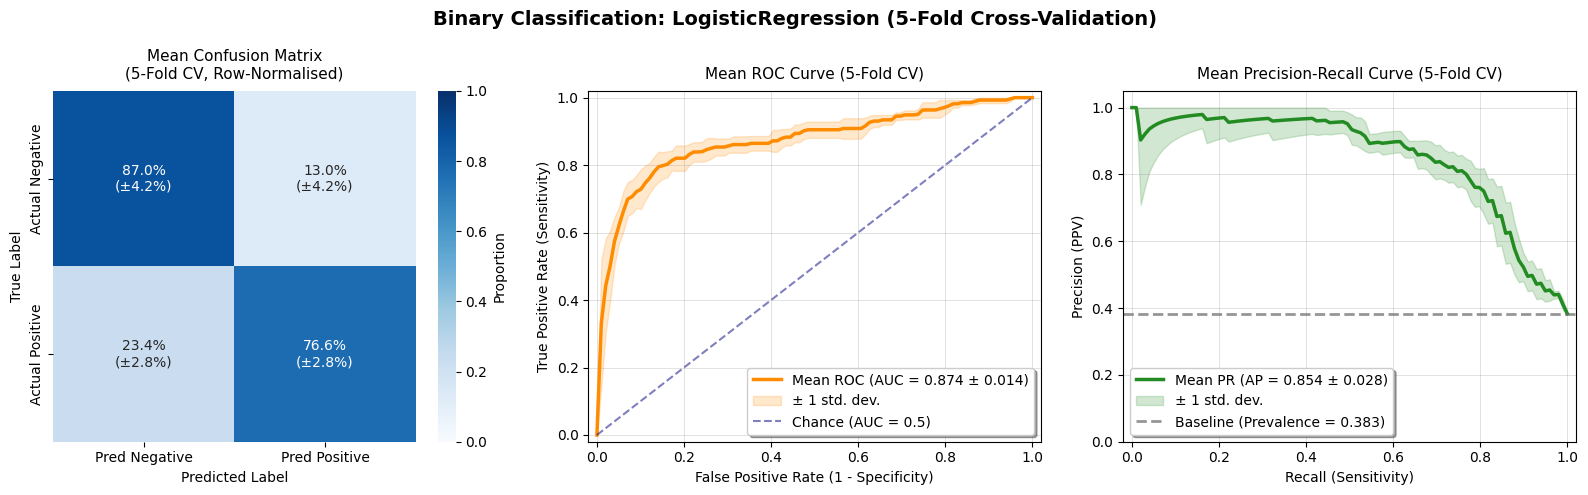

{'mean_auc': 0.8743725130088766,
 'std_auc': 0.014405846203729129,
 'mean_ap': 0.8535270715309593,
 'std_ap': 0.02814460155498107}

In [35]:
# Tabular metrics (5-fold CV)
base_logreg = evaluate_candidates(
	candidates={"LogisticRegression": logreg_pipe},
	X=X_train,
	y=y_train,
	n_splits=5,
	n_jobs=-1,
)
display(base_logreg)

# Visual diagnostics (confusion matrix, ROC, PR curve)
classification_evaluation(X=X_train, y=y_train, estimator=logreg_pipe)

## Candidate Model Evaluation

We evaluate multiple candidate models using 5-fold stratified cross-validation, comparing performance across accuracy, F1, and ROC-AUC.

### Ensemble Methods

Tree-based ensembles are natural candidates for this problem:
- **HistGradientBoostingClassifier**: fast gradient boosting with native categorical support.
- **RandomForestClassifier**: bagged decision trees, robust to overfitting.
- **AdaBoostClassifier**: sequential boosting of weak learners.

All ensembles are scale-invariant, so numeric scaling is disabled.

In [37]:
from sklearn.ensemble import (
	AdaBoostClassifier,
	HistGradientBoostingClassifier,
	RandomForestClassifier,
)

Evaluating HGB...
Evaluating RF...
Evaluating ADA...


,Model,test_accuracy (mean),test_accuracy (std),test_f1 (mean),test_f1 (std),test_roc_auc (mean),test_roc_auc (std)
0,HGB,0.821629,0.016312,0.756391,0.019899,0.887136,0.019338
1,ADA,0.823038,0.028219,0.775661,0.030506,0.873967,0.020728
2,RF,0.813218,0.022316,0.752283,0.029381,0.870664,0.017226



HGB
Unknown categories found in columns [3] will be encoded as zeros.


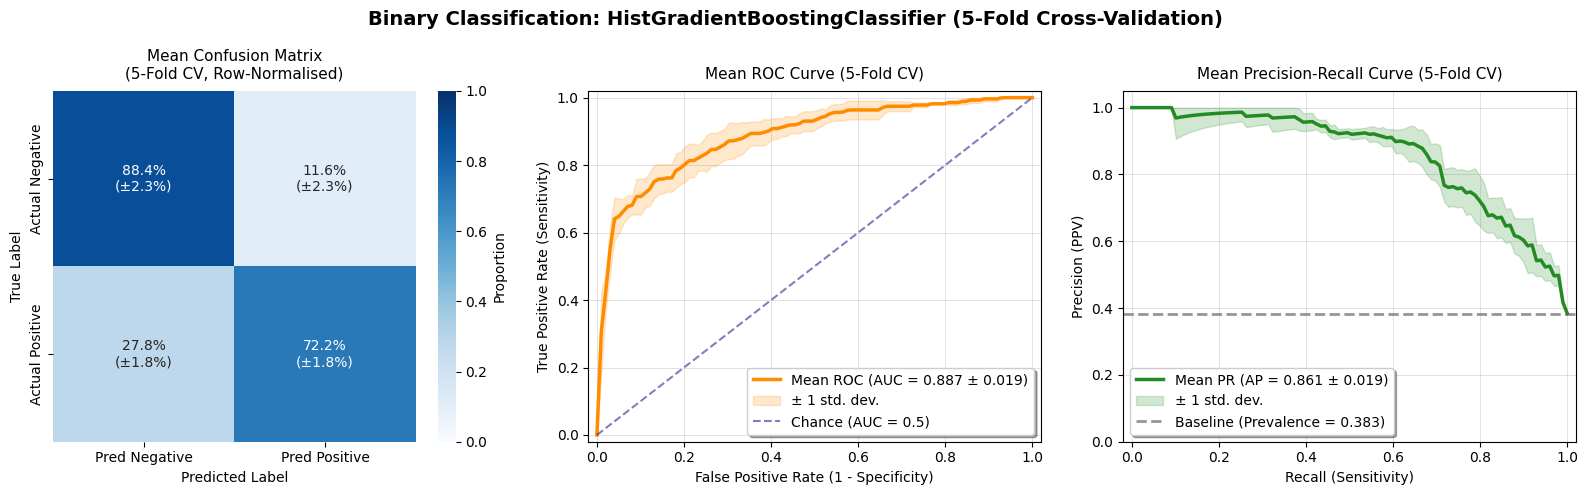


RF
Unknown categories found in columns [3] will be encoded as zeros.


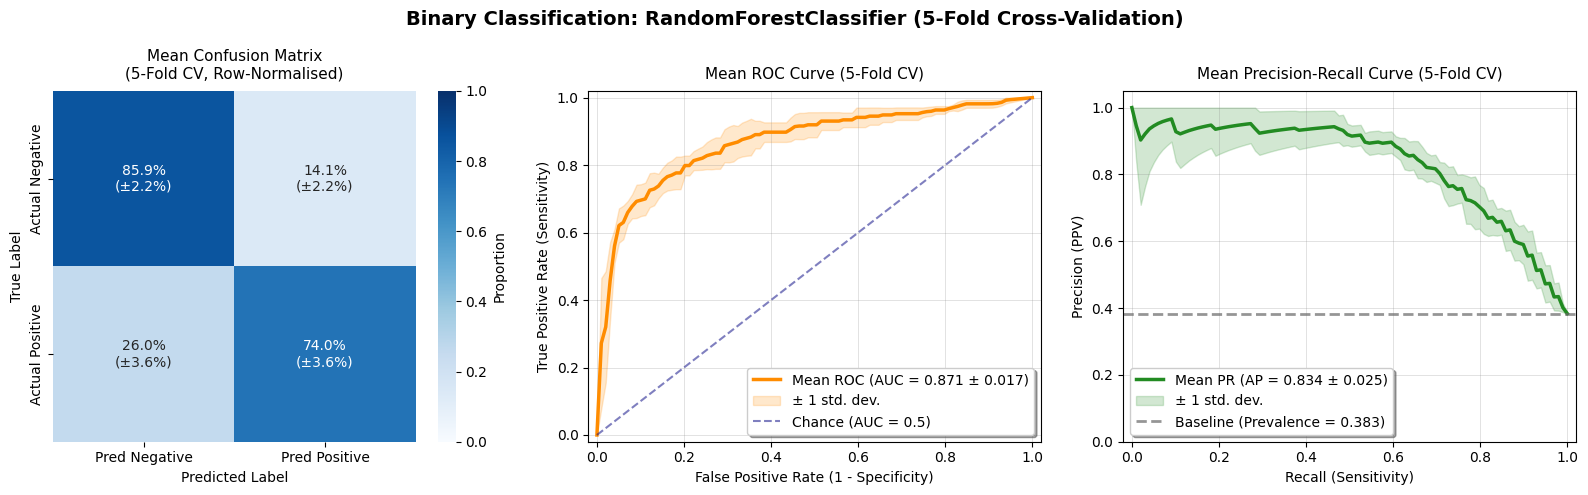


ADA
Unknown categories found in columns [3] will be encoded as zeros.


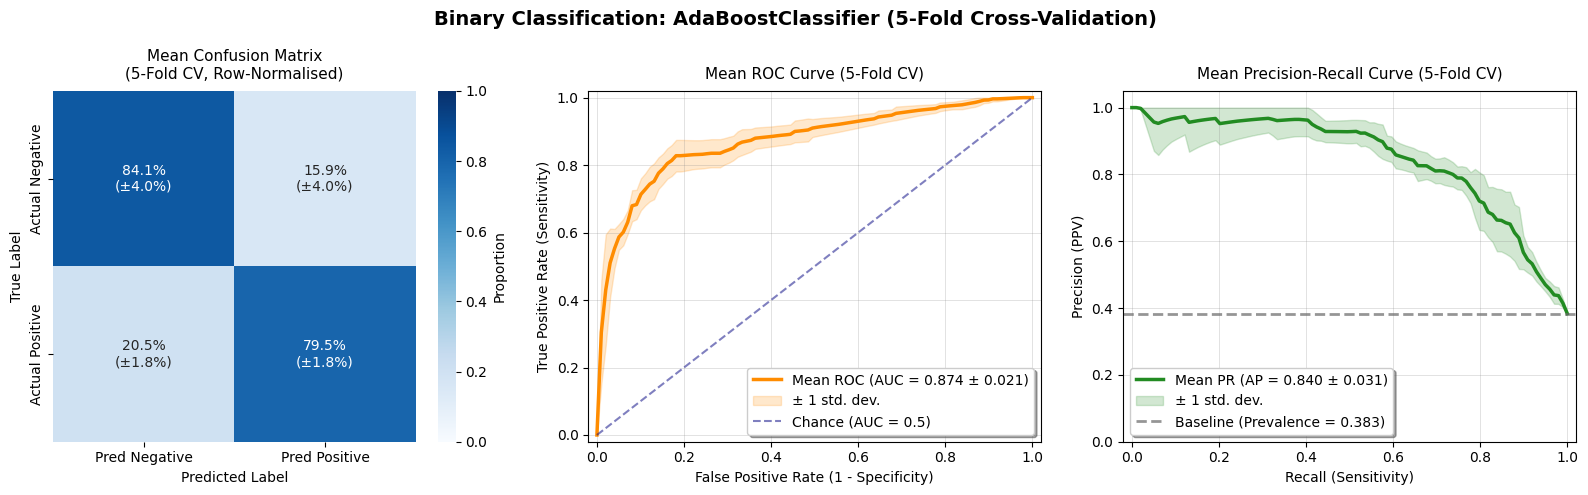

In [38]:
from sklearn.tree import DecisionTreeClassifier

ensemble_candidates = {
	"HGB": make_model_pipeline(
		model=HistGradientBoostingClassifier(random_state=42),
		cat_cols=cat_cols,
		num_cols=num_cols,
		scale_numeric=False,
	),
	"RF": make_model_pipeline(
		model=RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42),
		cat_cols=cat_cols,
		num_cols=num_cols,
		scale_numeric=False,
	),
	"ADA": make_model_pipeline(
		model=AdaBoostClassifier(
			estimator=DecisionTreeClassifier(max_depth=1),
			n_estimators=100,
			random_state=42,
		),
		cat_cols=cat_cols,
		num_cols=num_cols,
		scale_numeric=False,
	),
}

# Tabular comparison
evaluation_ensemble = evaluate_candidates(
	candidates=ensemble_candidates,
	X=X_train,
	y=y_train,
	n_splits=5,
	n_jobs=-1,
)

display(evaluation_ensemble)

for name, model in ensemble_candidates.items():
	print(f"\n{'=' * 60}\n{name}\n{'=' * 60}")
	classification_evaluation(X=X_train, y=y_train, estimator=model, cv=5, random_state=42)

### Gradient Boosting Libraries

We evaluate the three dominant gradient boosting implementations:
- **XGBoost**: the original high-performance gradient boosting library.
- **LightGBM**: Microsoft's histogram-based implementation, fast on large datasets.
- **CatBoost**: Yandex's implementation with native categorical feature support.

All are scale-invariant; numeric scaling is disabled.

In [41]:
!pip -q install catboost lightgbm xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 MB 13.6 MB/s eta 0:00:00


In [42]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

Evaluating XGBoost...
Evaluating LightGBM...
Evaluating CatBoost...


,Model,test_accuracy (mean),test_accuracy (std),test_f1 (mean),test_f1 (std),test_roc_auc (mean),test_roc_auc (std)
0,LightGBM,0.810381,0.025502,0.746798,0.033152,0.883760,0.017622
1,CatBoost,0.824466,0.023691,0.760224,0.030692,0.883659,0.024188
2,XGBoost,0.816025,0.020360,0.754628,0.022657,0.881833,0.016655



XGBoost
Unknown categories found in columns [3] will be encoded as zeros.


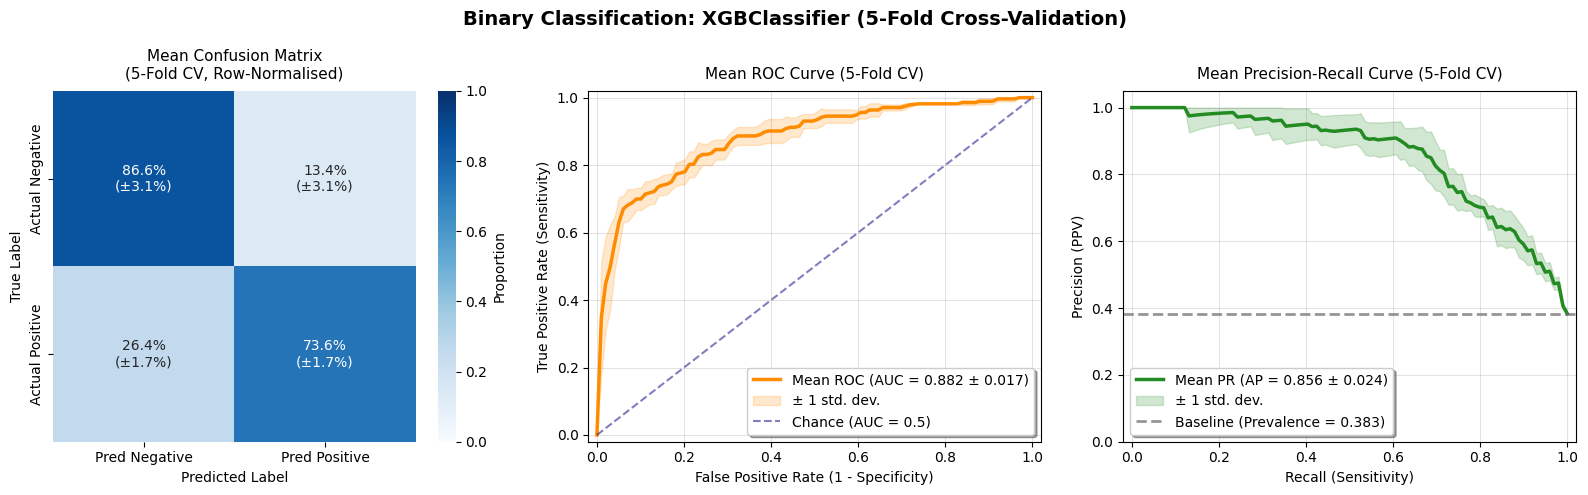


LightGBM
Unknown categories found in columns [3] will be encoded as zeros.


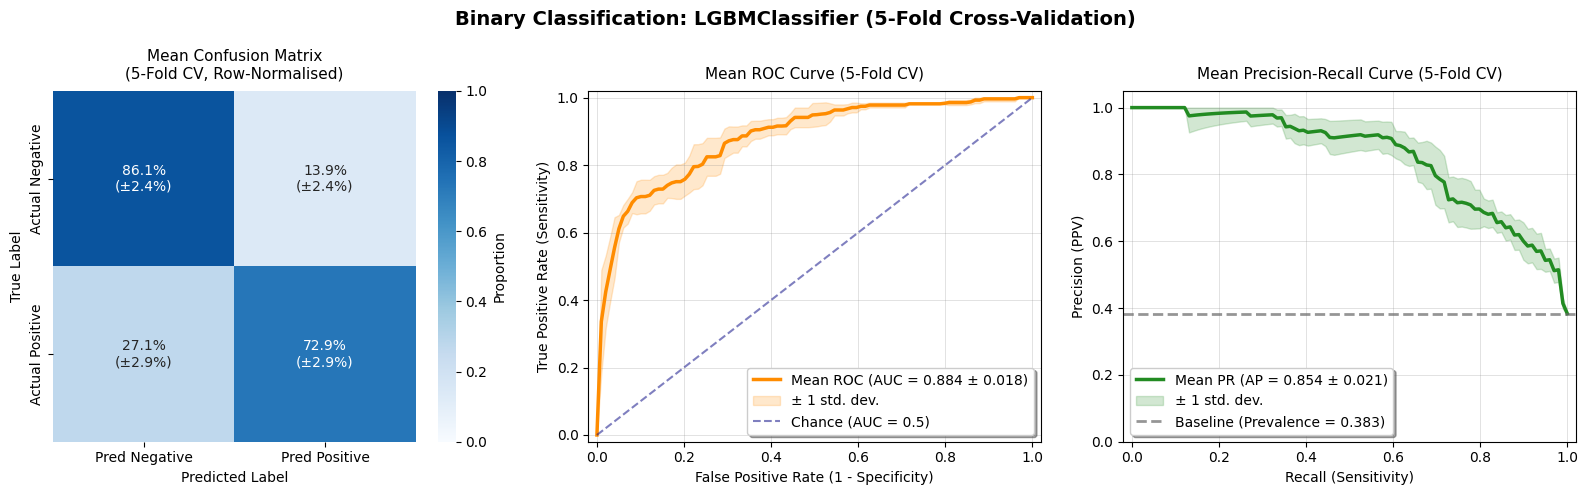


CatBoost
Unknown categories found in columns [3] will be encoded as zeros.


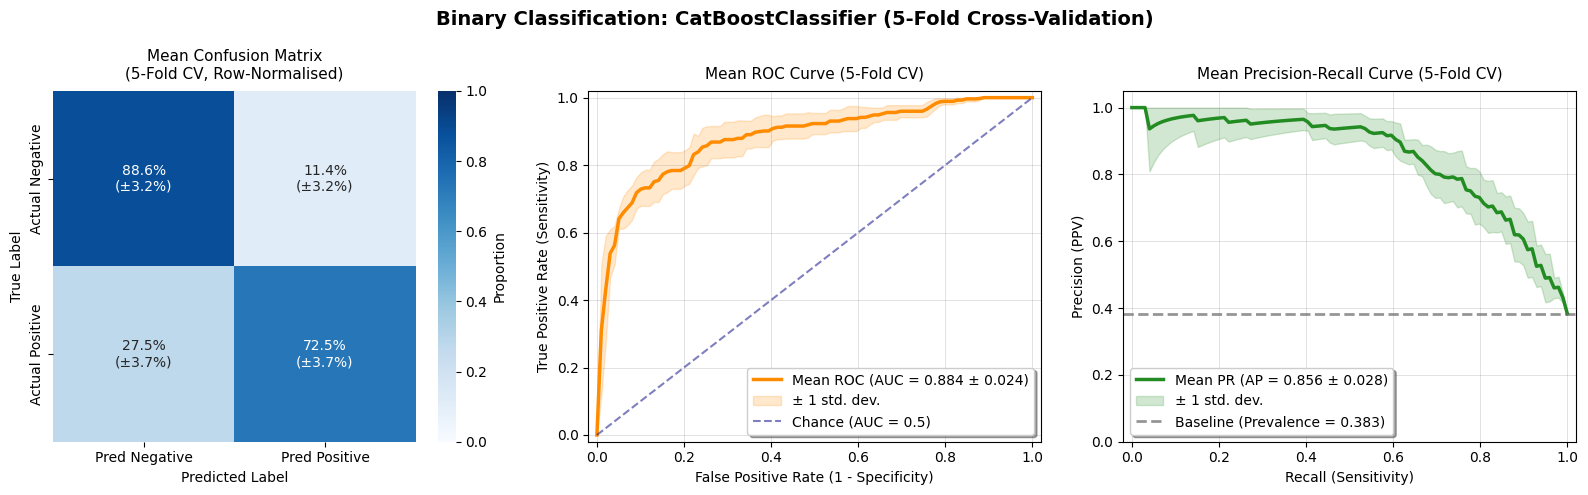

In [44]:
boost_candidates = {
    "XGBoost": make_model_pipeline(
        model=XGBClassifier(
            n_estimators=500,
            learning_rate=0.1,
            n_jobs=-1,
            random_state=42,
            use_label_encoder=False,
            eval_metric="logloss",
        ),
        cat_cols=cat_cols,
        num_cols=num_cols,
        scale_numeric=False,
    ),
    "LightGBM": make_model_pipeline(
        model=LGBMClassifier(
            n_estimators=200,
            learning_rate=0.1,
            n_jobs=1,
            random_state=42,
            verbose=-1),
        cat_cols=cat_cols,
        num_cols=num_cols,
        scale_numeric=False,
    ),
    "CatBoost": make_model_pipeline(
        model=CatBoostClassifier(
            iterations=200,
            learning_rate=0.1,
            random_state=42,
            verbose=0,
        ),
        cat_cols=cat_cols,
        num_cols=num_cols,
        scale_numeric=False,
    ),
}

# Tabular comparison (5-fold for consistency with other candidates)
evaluation_boost = evaluate_candidates(
    candidates=boost_candidates,
    X=X_train,
    y=y_train,
    n_splits=5,
    n_jobs=-1,
)
display(evaluation_boost)

# Visual diagnostics
for name, model in boost_candidates.items():
    print(f"\n{'='*60}\n{name}\n{'='*60}")
    classification_evaluation(X=X_train, y=y_train, estimator=model, cv=5, random_state=42)

In [55]:
def make_model_pipeline_flex(
    model,
    *,
    cat_cols: list[str],
    num_cols: list[str],
    cat_extra: list[str] | None = None,
    num_extra: list[str] | None = None,
    scale_numeric: bool = False,
) -> Pipeline:
    """
    Flexible pipeline factory that allows custom feature configuration.

    Parameters
    ----------
    model : estimator
        The classifier to use.
    cat_cols : list[str]
        Base categorical columns from raw data.
    num_cols : list[str]
        Base numeric columns from raw data.
    cat_extra : list[str] or None
        Additional categorical features created by feature engineering.
        If None, defaults to ["CabinCode", "FamilyCat", "Title"].
    num_extra : list[str] or None
        Additional numeric features created by feature engineering.
        If None, defaults to ["FamilySize", "Alone", "Missing_Age", "Missing_Cabin", "Missing_Embarked"].
    scale_numeric : bool
        Whether to apply StandardScaler to numeric features.

    Returns
    -------
    Pipeline
        Complete sklearn pipeline.
    """
    # Defaults
    if cat_extra is None:
        cat_extra = ["CabinCode", "FamilyCat", "Title"]
    if num_extra is None:
        num_extra = ["FamilySize", "Alone", "Missing_Age", "Missing_Cabin", "Missing_Embarked"]

    cat_cols_final = _dedupe_preserve_order(cat_cols + cat_extra)
    num_cols_final = _dedupe_preserve_order(num_cols + num_extra)

    return Pipeline(
        steps=[
            ("feat_eng", make_feature_engineering()),
            ("preprocess", make_preprocessor(cat_cols_final, num_cols_final, scale_numeric=scale_numeric)),
            ("model", model),
        ]
    )

In [51]:
from sklearn.ensemble import VotingClassifier

# Define base models (unfitted)
logreg = LogisticRegression(max_iter=5000, random_state=42)
hgb = HistGradientBoostingClassifier(random_state=42)
catboost = CatBoostClassifier(iterations=200, random_state=42, verbose=0)

# Create voting ensemble
voting_clf = VotingClassifier(
    estimators=[
        ("logreg", logreg),
        ("hgb", hgb),
        ("catboost", catboost),
    ],
    voting="soft",  # Average probabilities, then threshold
)

# Wrap in your pipeline
blend_pipe = make_model_pipeline(
    model=voting_clf,
    cat_cols=cat_cols,
    num_cols=num_cols,
    scale_numeric=False,  # Tree models don't need scaling; LogReg will cope
)

# Evaluate
blend_results = evaluate_candidates(
    candidates={"VotingEnsemble": blend_pipe},
    X=X_train,
    y=y_train,
    n_splits=5,
    n_jobs=1,  # Nested parallelism issues otherwise
)
display(blend_results)

Evaluating VotingEnsemble...


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Model,test_accuracy (mean),test_accuracy (std),test_f1 (mean),test_f1 (std),test_roc_auc (mean),test_roc_auc (std)
0,VotingEnsemble,0.824476,0.017894,0.760121,0.022568,0.893785,0.021399


In [52]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[
        ("logreg", LogisticRegression(max_iter=5000, random_state=42)),
        ("hgb", HistGradientBoostingClassifier(random_state=42)),
        ("rf", RandomForestClassifier(n_estimators=200, random_state=42)),
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1,
)

stack_pipe = make_model_pipeline(
    model=stacking_clf,
    cat_cols=cat_cols,
    num_cols=num_cols,
    scale_numeric=False,
)

evaluate_candidates(
    candidates={"Stacking": stack_pipe},
    X=X_train,
    y=y_train,
    n_splits=5,
    n_jobs=1,
)
display(blend_results)

Evaluating Stacking...


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Model,test_accuracy (mean),test_accuracy (std),test_f1 (mean),test_f1 (std),test_roc_auc (mean),test_roc_auc (std)
0,VotingEnsemble,0.824476,0.017894,0.760121,0.022568,0.893785,0.021399


### Final Model and Kaggle Submission

For submission, we:
1. Load the held-out test set from GitHub.
2. Retrain the selected model (LightGBM) on the **full** training data to maximise available signal.
3. Generate predictions and export in Kaggle's required format.

In [46]:
TEST_URL = (
    "https://raw.githubusercontent.com/jhlopesalves/"
    "classic_workflows/main/supervised_learning/classification/titanic/data/test.csv"
)

test = pd.read_csv(TEST_URL)

# Align columns to training set features
X_kaggle_test = test[X.columns].copy()

# Final model: LightGBM (selected based on CV performance)
final_model = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.1,
    n_jobs=-1,
    random_state=42,
    verbose=-1,
)

final_pipe = make_model_pipeline(
    model=final_model,
    cat_cols=cat_cols,
    num_cols=num_cols,
    scale_numeric=False,
)

# Fit on full training data
final_pipe.fit(X, y)

# Generate predictions
predictions = final_pipe.predict(X_kaggle_test).astype(int)

# Create submission file
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": predictions,
})
submission.to_csv("submission.csv", index=False)

print(f"Submission shape: {submission.shape}")
submission.head()

Submission shape: (418, 2)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


## Final Submissions: Comparative Testing

To isolate the source of the gap between CV performance and Kaggle score, we submit three candidate models with different feature configurations:

1. **LogReg (full features)**: Best CV accuracy (0.830), all engineered features included.
2. **LogReg (bare bones)**: Minimal feature set, tests whether simpler generalises better.
3. **VotingEnsemble**: Best ROC-AUC (0.894), combines LogReg + HGB + CatBoost.



In [69]:
# Fix: Impute missing Fare in test set (standard Titanic issue) using training median
X_kaggle_test["Fare"] = X_kaggle_test["Fare"].fillna(X["Fare"].median())

# 1. LogReg with full features
logreg_full = make_model_pipeline_flex(
    model=LogisticRegression(max_iter=5000, random_state=42),
    cat_cols=cat_cols,
    num_cols=num_cols,
    cat_extra=["CabinCode", "FamilyCat", "Title"],
    num_extra=["FamilySize", "Alone", "Missing_Age", "Missing_Cabin", "Missing_Embarked"],
    scale_numeric=True,
)
logreg_full.fit(X, y)
pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": logreg_full.predict(X_kaggle_test).astype(int),
}).to_csv("submission_logreg_full.csv", index=False)

# 2. LogReg bare_bones (simpler might generalise better)
logreg_bare = make_model_pipeline_flex(
    model=LogisticRegression(max_iter=5000, random_state=42),
    cat_cols=cat_cols,
    num_cols=num_cols,
    cat_extra=[],
    num_extra=["FamilySize"],
    scale_numeric=True,
)
logreg_bare.fit(X, y)
pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": logreg_bare.predict(X_kaggle_test).astype(int),
}).to_csv("submission_logreg_bare.csv", index=False)

# 3. VotingEnsemble (best ROC-AUC, might translate to accuracy)
# Use your existing blend_pipe
blend_pipe.fit(X, y)
pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": blend_pipe.predict(X_kaggle_test).astype(int),
}).to_csv("submission_voting.csv", index=False)